In [1]:
#!pip install -U scikit-learn
%time
import time
for _ in range(1000):
    time.sleep(0.01)# sleep for 0.01 seconds

CPU times: user 0 ns, sys: 2 µs, total: 2 µs
Wall time: 4.53 µs


In [2]:
!python3 --version
!pip3 --version
!virtualenv --version
!scikit-learn --version
print('Done')

Python 3.7.1
pip 18.1 from /home/eric/anaconda3/lib/python3.7/site-packages/pip (python 3.7)
16.1.0
/bin/sh: 1: scikit-learn: not found
Done


https://www.kaggle.com/c/web-traffic-time-series-forecasting/data

https://www.kaggle.com/muonneutrino/wikipedia-traffic-data-exploration

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re
from geopandas import GeoDataFrame
from shapely.geometry import Point
import geopandas as gpd
import networkx as nx

%matplotlib inline

In [4]:
!pwd && ls

/home/eric/Google/DPP/DC_Cost_Optimization/cloud_network/cloud_network
 addresses.txt				        key_2.csv
 app.py					        keyed_tables.py
 average_use.eps			        latencies.html
 average_use.jpg			        MatplotlibExample.ipynb
 average_use.png			        nearest_points.py
 convert_mb.py				        PKS_suuralue.kml
 coords.csv				        __pycache__
 -Copy1.ipynb				        queueing.py
 distance_conversion.py			        replicas.py
 filename.joblib			        sample_submission_1.csv
 forecasting_wan_paper_12102918.ipynb	        sample_submission_2.csv
 forecasting_wan_paper-12222018.ipynb	       'Sci-kit learn.ipynb'
 forecasting_wan_paper.ipynb		        tempBrowseLocal.html
 forecasting_wan_paper-train1r_12302018.ipynb   temp-plot.html
 forecasting_wan_paper-train2_01122019.ipynb    throughput
 forecasting_wan_paper-train2_02162019.ipynb    train_1.csv
 forecasts				        train_2.csv
 Frequency_labs.ipynb			        t_uncongested.py
 geocodes-final.ipynb			        Untitled1.ipyn

In [5]:
key_1='key_1.csv'
key_2='key_2.csv'
train_1='train_1.csv'
train_2='train_2.csv'
ss_1='sample_submission_1.csv'
ss_2='sample_submission_2.csv'

In [6]:
def pd_open(file):
    return pd.read_csv(file).fillna(0)

df_key_1=pd_open(key_1)
#ss_1=pd.read_csv(ss_1).fillna(0)
#ss_1.head()
df_key_1.head()

Page            Id
0  !vote_en.wikipedia.org_all-access_all-agents_2...  bf4edcf969af
1  !vote_en.wikipedia.org_all-access_all-agents_2...  929ed2bf52b9
2  !vote_en.wikipedia.org_all-access_all-agents_2...  ff29d0f51d5c
3  !vote_en.wikipedia.org_all-access_all-agents_2...  e98873359be6
4  !vote_en.wikipedia.org_all-access_all-agents_2...  fa012434263a

In [7]:
train1=pd.read_csv(train_1).fillna(0)
train2=pd.read_csv(train_2).fillna(0)
#train2.head()

In [8]:
train1.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         0.0         0.0   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   2015-07-09     ...      2016-12-22  2016-12-23  2016-12-24  2016-12-25  \
0        26.0     ...            32.0        63.0        15.0        26.0   
1        10.0     ...            17.0        42.0        28.0        15.0   
2         4.0     ...             3.0         1.0         1.0         7.0   
3        11.0     ...            32.0        10.0        26.0        27.0   
4         0.0     ...            48.0         9.0        25.0        13.0   

   2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
0        14.0        20.0        22.0        19.0        18.0        20.0  
1         9.0        30.0        52.0        45.0        26.0        20.0  
2         4.0         4.0         6.0         3.0         4.0        17.0  
3        16.0        11.0        17.0        19.0        10.0        11.0  
4         3.0        11.0        27.0        13.0        36.0        10.0  

[5 rows x 551 columns]

In [9]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 804 entries, Page to 2017-09-10
dtypes: float64(803), object(1)
memory usage: 889.8+ MB


In [10]:
#train=pd.concat([train1, train2], sort=False)
train = train1.copy() #train2 is inclusive of train1 but has a longer range of data. The difference is what will be used as test data.

In [11]:
# Commented out for now to stop errors with some of the statsmodels methods
for col in train.columns[1:]:
    train[col] = pd.to_numeric(train[col],downcast='integer')
train.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider          18          11   
1             2PM_zh.wikipedia.org_all-access_spider          11          14   
2              3C_zh.wikipedia.org_all-access_spider           1           0   
3         4minute_zh.wikipedia.org_all-access_spider          35          13   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...           0           0   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0           5          13          14           9           9          22   
1          15          18          11          13          22          11   
2           1           1           0           4           0           3   
3          10          94           4          26          14           9   
4           0           0           0           0           0           0   

   2015-07-09     ...      2016-12-22  2016-12-23  2016-12-24  2016-12-25  \
0          26     ...              32          63          15          26   
1          10     ...              17          42          28          15   
2           4     ...               3           1           1           7   
3          11     ...              32          10          26          27   
4           0     ...              48           9          25          13   

   2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
0          14          20          22          19          18          20  
1           9          30          52          45          26          20  
2           4           4           6           3           4          17  
3          16          11          17          19          10          11  
4           3          11          27          13          36          10  

[5 rows x 551 columns]

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: int32(550), object(1)
memory usage: 305.5+ MB


In [13]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'na'

train['lang'] = train.Page.map(get_language)

from collections import Counter

print(Counter(train.lang))

Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


<ul>
<li>loc gets rows (or columns) with particular labels from the index.</li>
<li>iloc gets rows (or columns) at particular positions in the index (so it only takes integers).</li>
<li>ix usually tries to behave like loc but falls back to behaving like iloc if a label is not present in the index.</li></ul>

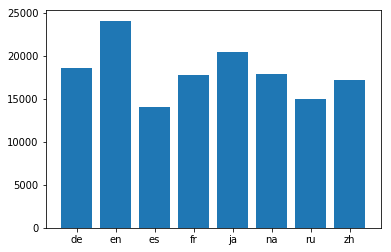

In [14]:
#plt.plot(*zip(*sorted(concentration.items())))
#plt.show()
lang_dist=Counter(train.lang)
plt.bar(*zip(*sorted(lang_dist.items())))
plt.show()

In [15]:
lang_2_pg_size = pd.DataFrame.from_dict(Counter(train.lang), orient='index')
lang_2_pg_size['Language'] = ['Mandarin','French','English','na','Russian','German','Japanese','Spanish']
lang_2_pg_size['Word_length'] = [1,10.9,8.23,0,9.97,11.66,1,8.8]
lang_2_pg_size['Words_per_page'] = [1032,640,640,0,640,640,1600,640]
lang_2_pg_size['Bytes_per_character'] = [2,1,1,0,1,1,2,1]
lang_2_pg_size['Bytes_per_page']=lang_2_pg_size['Word_length']*lang_2_pg_size['Words_per_page']*lang_2_pg_size['Bytes_per_character']
lang_2_pg_size['bits_per_page']=lang_2_pg_size['Bytes_per_page'].astype(float) * 8
lang_2_pg_size

0  Language  Word_length  Words_per_page  Bytes_per_character  \
zh  17229  Mandarin         1.00            1032                    2   
fr  17802    French        10.90             640                    1   
en  24108   English         8.23             640                    1   
na  17855        na         0.00               0                    0   
ru  15022   Russian         9.97             640                    1   
de  18547    German        11.66             640                    1   
ja  20431  Japanese         1.00            1600                    2   
es  14069   Spanish         8.80             640                    1   

    Bytes_per_page  bits_per_page  
zh          2064.0        16512.0  
fr          6976.0        55808.0  
en          5267.2        42137.6  
na             0.0            0.0  
ru          6380.8        51046.4  
de          7462.4        59699.2  
ja          3200.0        25600.0  
es          5632.0        45056.0

In [16]:
lang_2_pg_size.loc['en','bits_per_page']

42137.600000000006

In [17]:
train['lang'].unique()

array(['zh', 'fr', 'en', 'na', 'ru', 'de', 'ja', 'es'], dtype=object)

In [18]:
lang_sets = {}
lang_sets['en'] = train[train.lang=='en'].iloc[:,0:-1]
lang_sets['ja'] = train[train.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = train[train.lang=='de'].iloc[:,0:-1]
#lang_sets['na'] = train[train.lang=='na'].iloc[:,0:-1] Not using media
lang_sets['fr'] = train[train.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = train[train.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = train[train.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = train[train.lang=='es'].iloc[:,0:-1]
    
# Hits for each day are summed per language. Then the total per day is averaged per page.
## I just run the mean function.
sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].mean()*lang_2_pg_size.loc[key,'bits_per_page']#  / lang_sets[key].shape[0] #axis=0 is said to be "column-wise" (and axis=1 "row-wise"),

page_popularity = {}
for key in lang_sets:
    page_popularity[key] = lang_sets[key].reset_index().iloc[:,1:].sum(axis=1)

In [19]:
sums['en'].head()

2015-07-01    1.480657e+08
2015-07-02    1.475874e+08
2015-07-03    1.401226e+08
2015-07-04    1.458827e+08
2015-07-05    1.506638e+08
dtype: float64

In [20]:
# Hits for each day are summed per language. Then the total per day is averaged per page.
## I just run the mean function.
quantile = {}
for key in lang_sets:
    quantile[key] = lang_sets[key].iloc[:,1:].quantile(0.95)*lang_2_pg_size.loc[key,'bits_per_page']#  / lang_sets[key].shape[0] #axis=0 is said to be "column-wise" (and axis=1 "row-wise"),

In [21]:
en_lang = lang_sets['en'].describe().T
en_lang = en_lang.rename(columns=lambda x: 'en_' + x)

ru_lang = lang_sets['ru'].describe().T
ru_lang = ru_lang.rename(columns=lambda x: 'ru_' + x)

en_ru_2016=pd.concat([en_lang,ru_lang], axis=1)
en_ru_corr=en_ru_2016[[
 'en_mean',
 'en_std', 
 'en_25%',
 'en_50%', 
 'en_75%',
 'en_max', 
 'ru_mean','ru_std','ru_25%','ru_50%','ru_75%','ru_max',]].corr()

#en_ru_corr

In [22]:
"""en_ru_2016.plot(subplots=True, layout=(4, 4), figsize=(12, 8), sharex=False);"""

'en_ru_2016.plot(subplots=True, layout=(4, 4), figsize=(12, 8), sharex=False);'

In [23]:
#page_popularity['en'].sort_values(ascending = False).head(10)
#quantile['en']

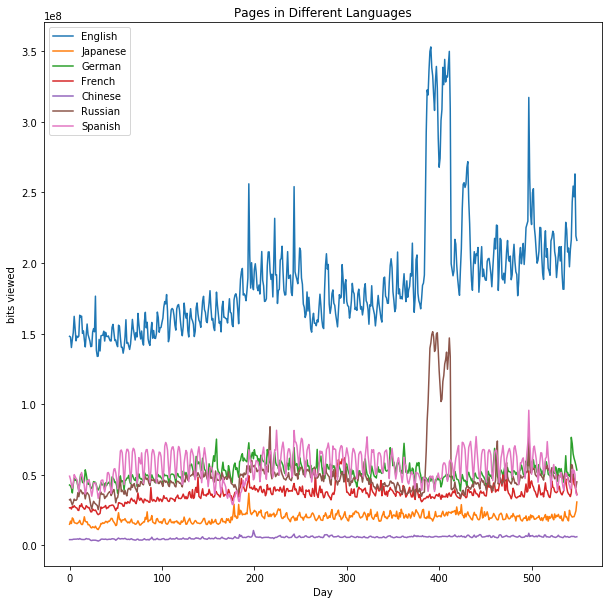

In [24]:
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1,figsize=[10,10])
plt.ylabel('bits viewed')
plt.xlabel('Day')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }
'''
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }
'''
for key in sums:
    plt.plot(days,sums[key],label = labels[key] )
    
plt.legend()
#plt.savefig('/home/eric/Google/DPP/DC_Cost_Optimization/cloud_network/Conference-LaTeX-template_7-9-18/average_use.jpg') 
plt.show()


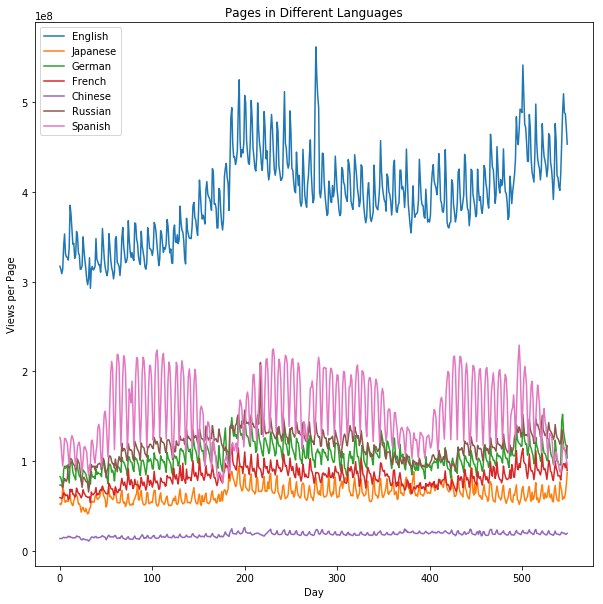

In [25]:
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }
'''
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }
'''
for key in quantile:
    plt.plot(days,quantile[key],label = labels[key] )
    
plt.legend()
#plt.savefig('/home/eric/Google/DPP/DC_Cost_Optimization/cloud_network/Conference-LaTeX-template_7-9-18/quantile95_use.jpg') 
plt.show()

In [26]:
(78)/days[-1]

0.14207650273224043

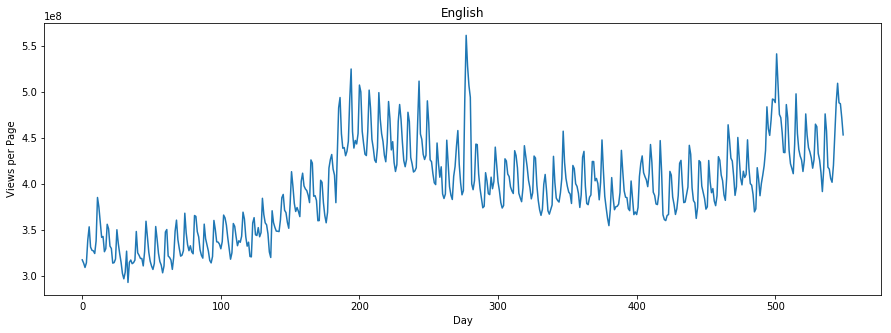

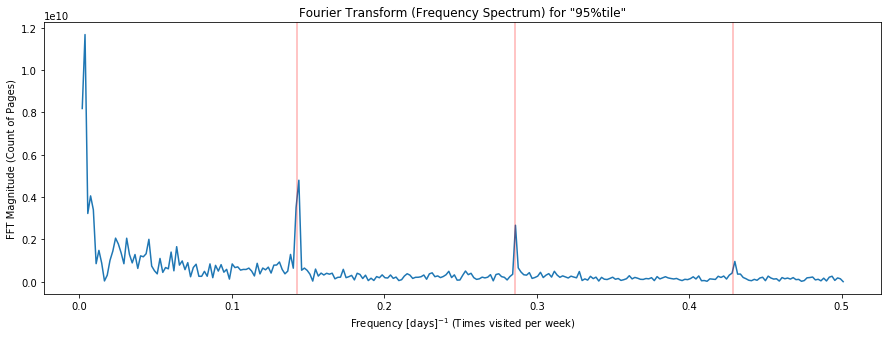

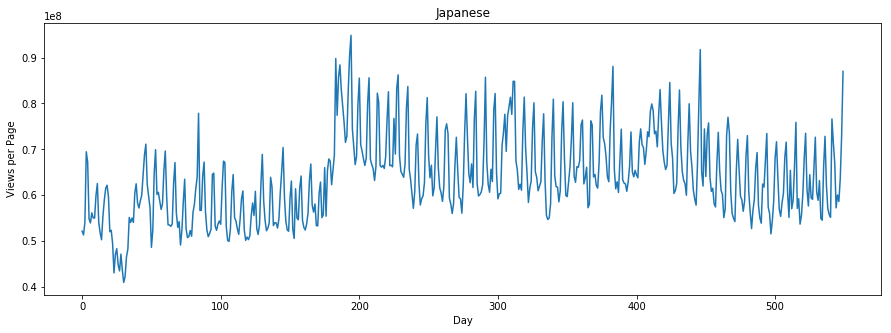

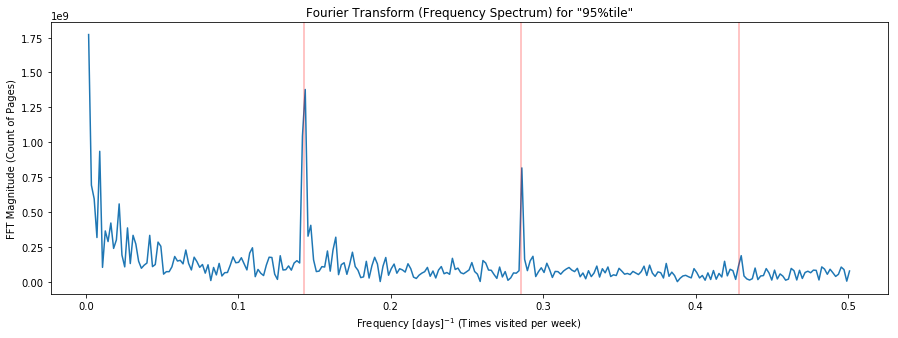

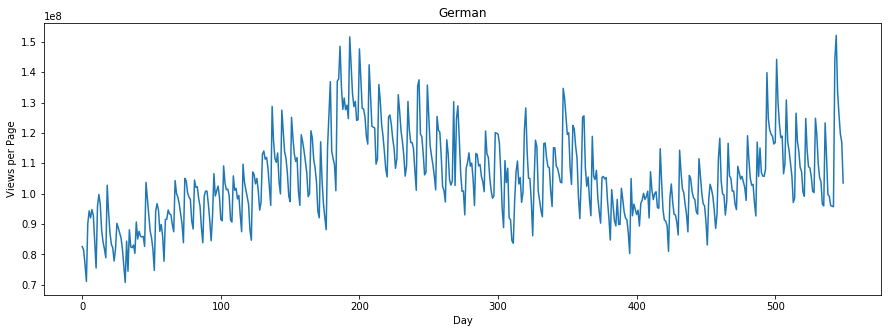

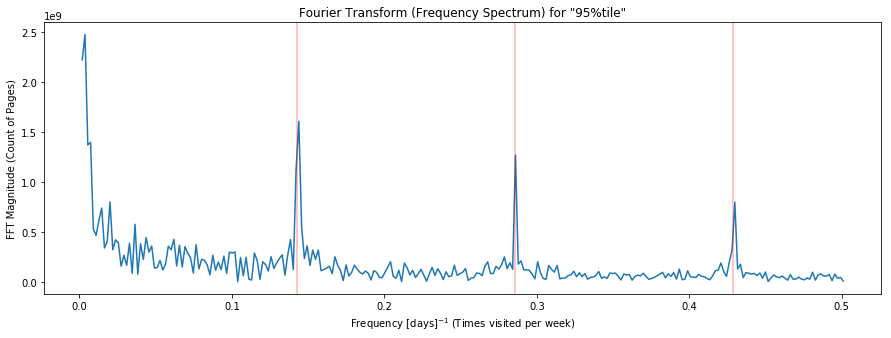

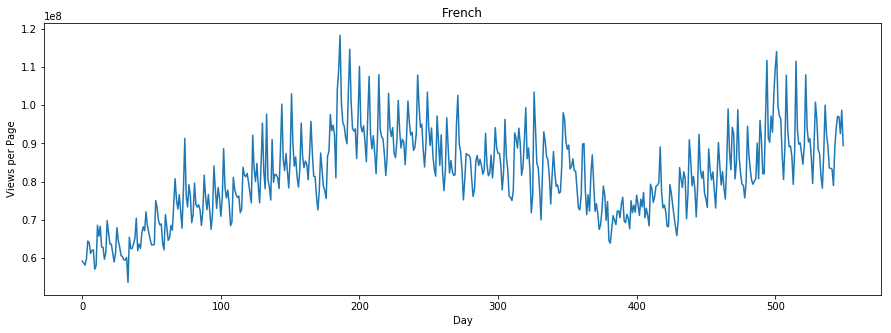

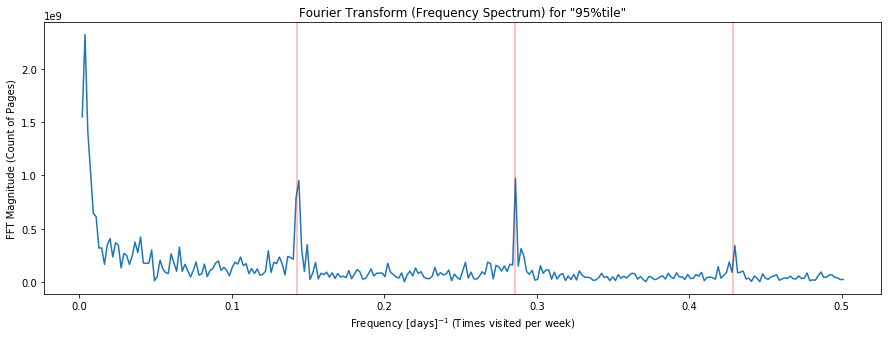

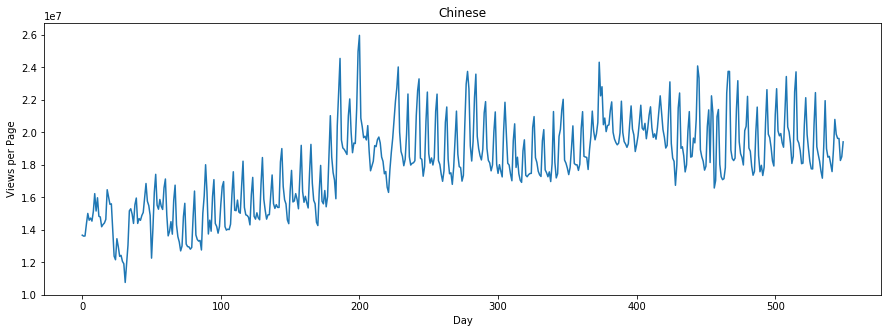

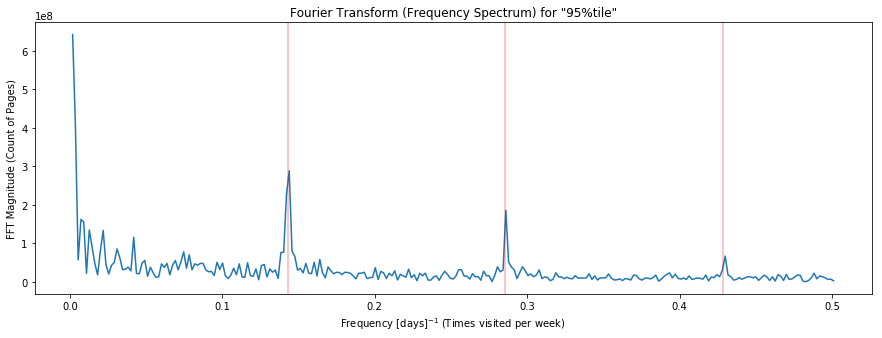

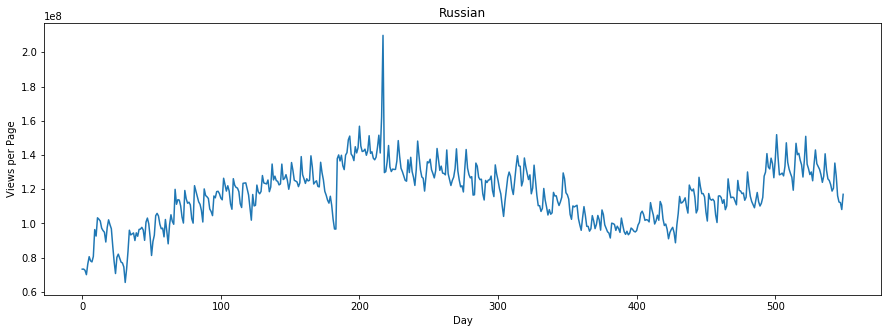

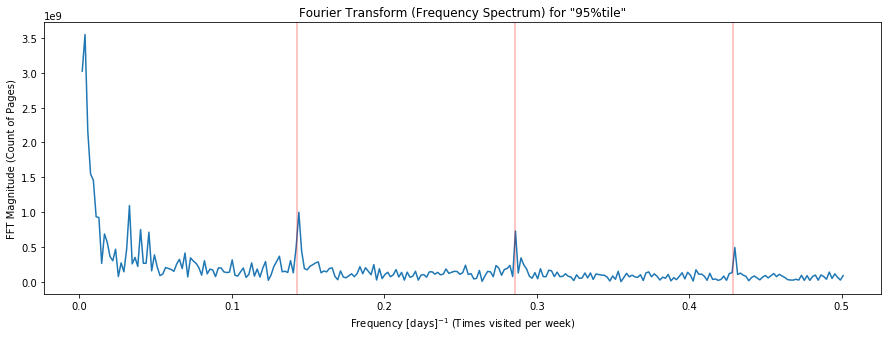

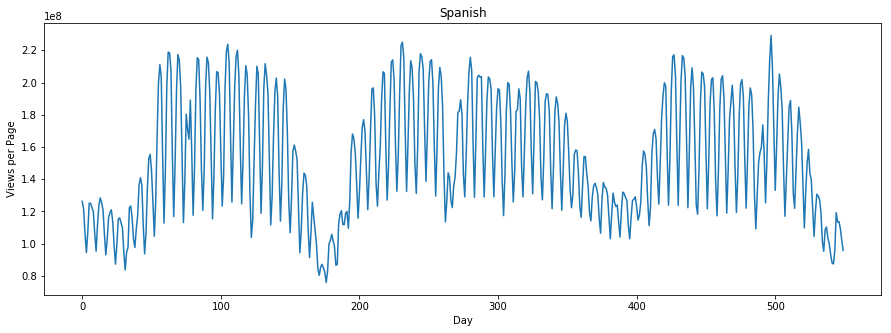

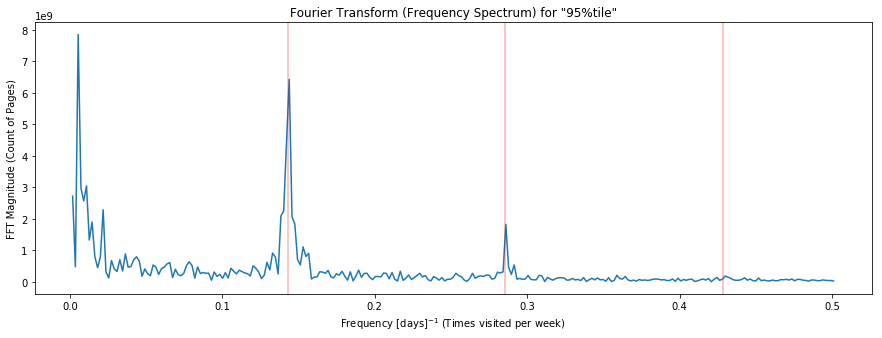

In [27]:
from scipy.fftpack import fft
def plot_with_fft(key):

    fig = plt.figure(1,figsize=[15,5])
    plt.ylabel('Views per Page')
    plt.xlabel('Day')
    plt.title(labels[key])
    plt.plot(days,quantile[key],label = labels[key] )
    
    fig = plt.figure(2,figsize=[15,5])
    fft_complex = fft(quantile[key]) #fft function provides teh comples number.
    fft_mag = [np.sqrt(np.real(x)*np.real(x)+np.imag(x)*np.imag(x)) for x in fft_complex]
    fft_xvals = [day / days[-1] for day in days] #makes x-axis show the fraction each day is the sample range
    npts = len(fft_xvals) // 2 + 1 #fllor divsion, whole number rounded to left integer
    fft_mag = fft_mag[:npts]
    fft_xvals = fft_xvals[:npts]
        
    plt.ylabel('FFT Magnitude (Count of Pages)')
    plt.xlabel(r"Frequency [days]$^{-1}$ (Times visited per week)")
    plt.title('Fourier Transform (Frequency Spectrum) for "95%tile"')
    plt.plot(fft_xvals[1:],fft_mag[1:],label = labels[key] )
    # Draw lines at 1, 1/2, and 1/3 week periods
    plt.axvline(x=1./7,color='red',alpha=0.3)
    plt.axvline(x=2./7,color='red',alpha=0.3)
    plt.axvline(x=3./7,color='red',alpha=0.3)

    plt.show()

for key in quantile:
    plot_with_fft(key)

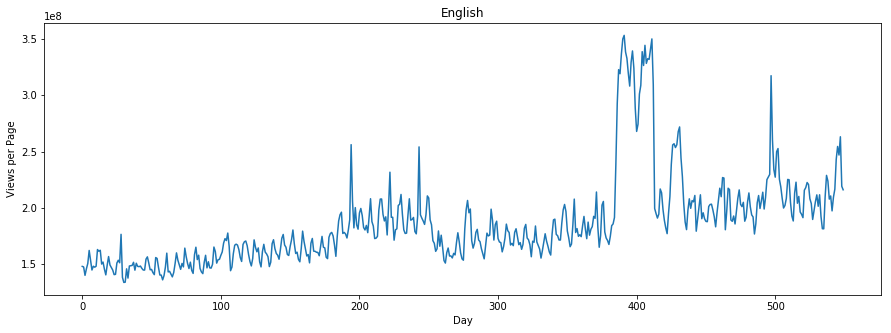

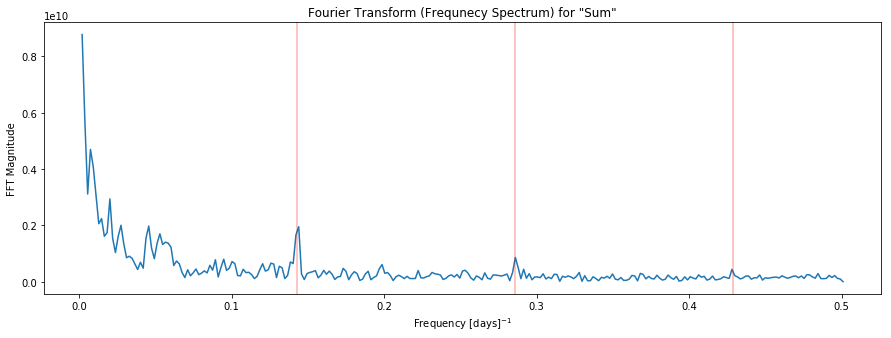

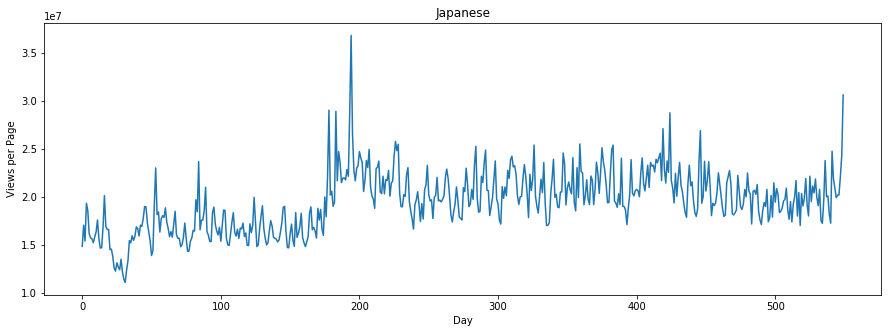

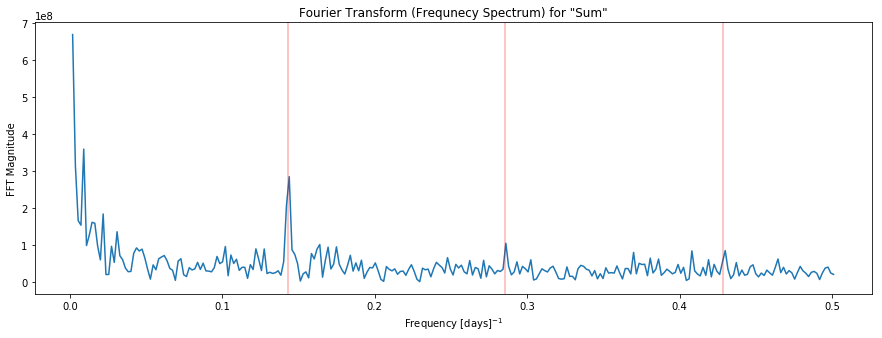

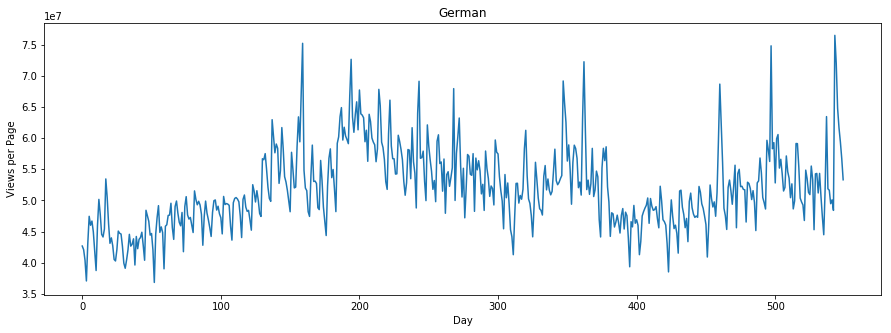

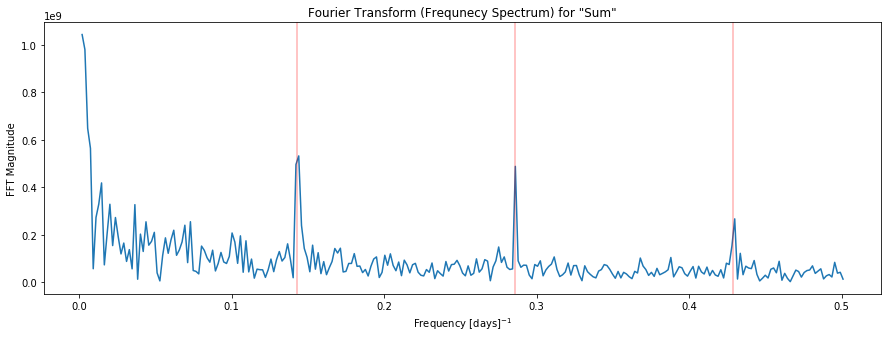

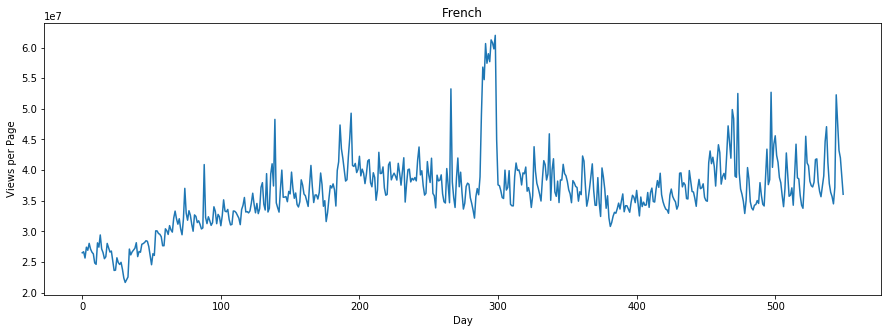

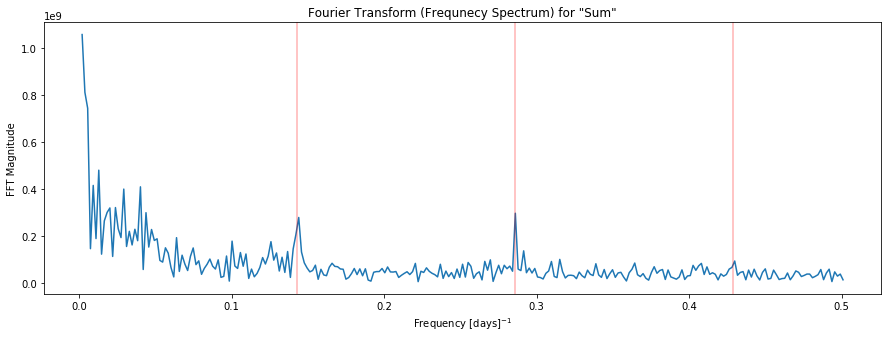

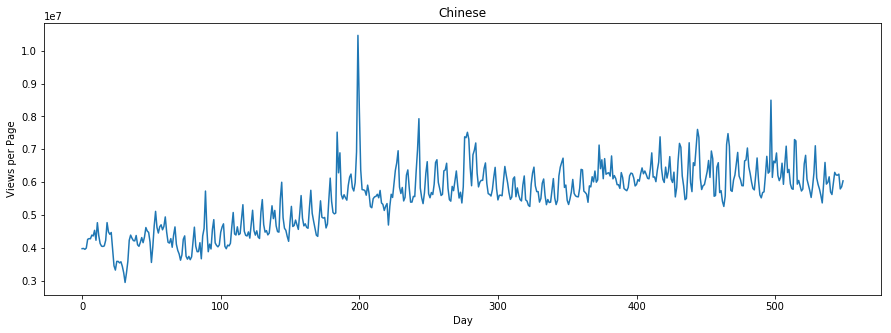

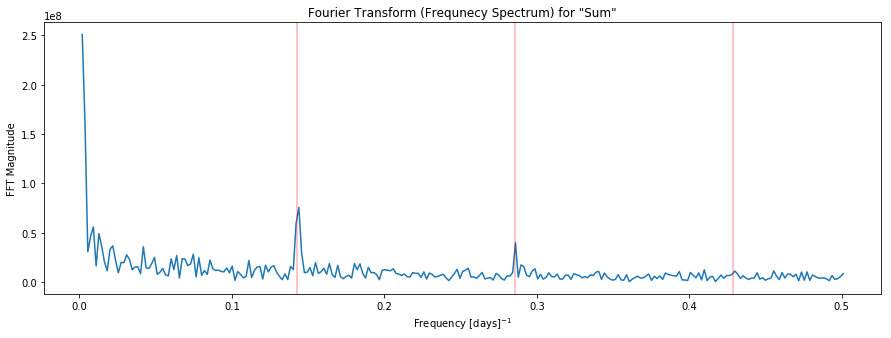

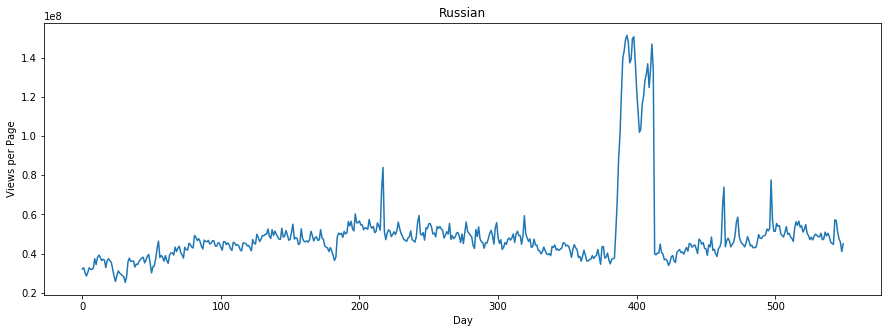

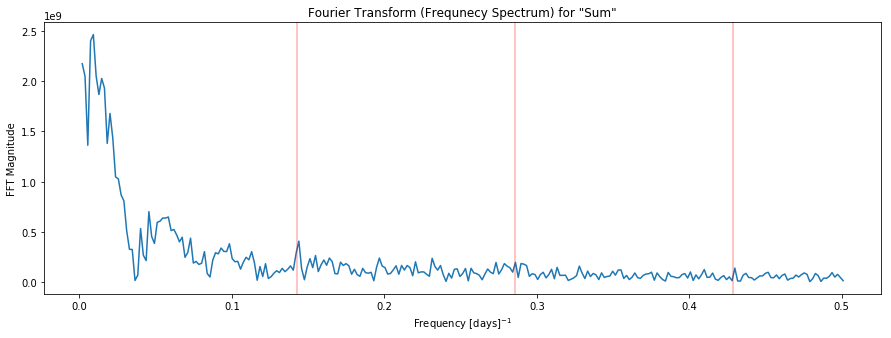

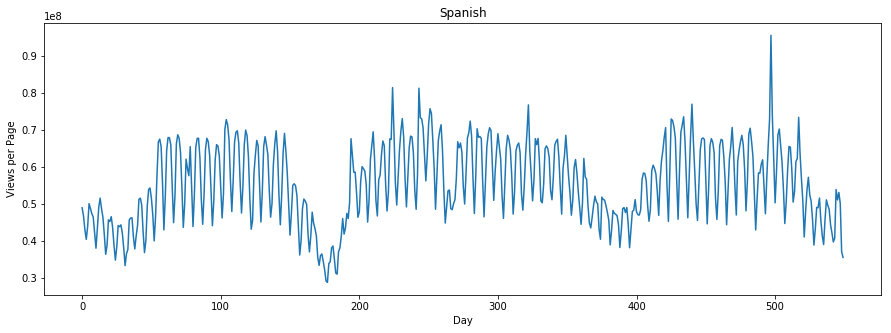

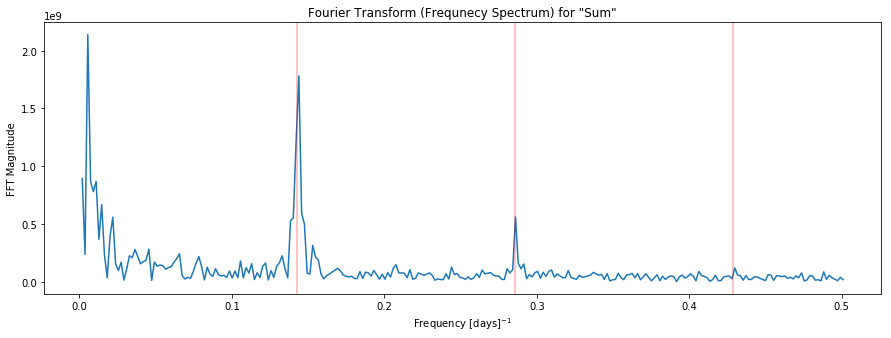

In [28]:
from scipy.fftpack import fft
def plot_with_fft(key):

    fig = plt.figure(1,figsize=[15,5])
    plt.ylabel('Views per Page')
    plt.xlabel('Day')
    plt.title(labels[key])
    plt.plot(days,sums[key],label = labels[key] )
    
    fig = plt.figure(2,figsize=[15,5])
    fft_complex = fft(sums[key])
    fft_mag = [np.sqrt(np.real(x)*np.real(x)+np.imag(x)*np.imag(x)) for x in fft_complex]
    fft_xvals = [day / days[-1] for day in days]
    npts = len(fft_xvals) // 2 + 1
    fft_mag = fft_mag[:npts]
    fft_xvals = fft_xvals[:npts]
        
    plt.ylabel('FFT Magnitude')
    plt.xlabel(r"Frequency [days]$^{-1}$")
    plt.title('Fourier Transform (Frequnecy Spectrum) for "Sum"')
    plt.plot(fft_xvals[1:],fft_mag[1:],label = labels[key] )
    # Draw lines at 1, 1/2, and 1/3 week periods
    plt.axvline(x=1./7,color='red',alpha=0.3)
    plt.axvline(x=2./7,color='red',alpha=0.3)
    plt.axvline(x=3./7,color='red',alpha=0.3)

    plt.show()

for key in sums:
    plot_with_fft(key)

In [29]:
#fft_complex

In [30]:
#import gc
#gc.get_objects()
#locals()
#get_objects

In [31]:
def plot_entry(key,idx):
    data = lang_sets[key].iloc[idx,1:]
    fig = plt.figure(1,figsize=(10,5))
    plt.plot(days,data)
    plt.xlabel('day')
    plt.ylabel('views')
    plt.title(train.iloc[lang_sets[key].index[idx],0])
    
    plt.show()

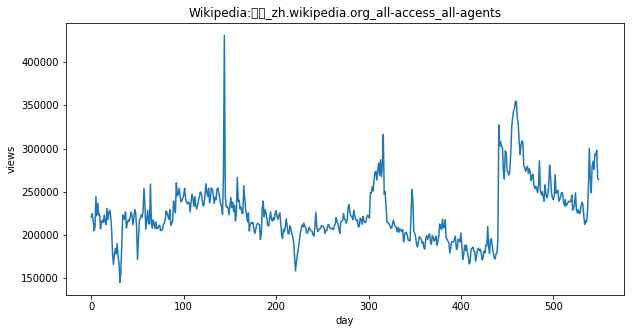

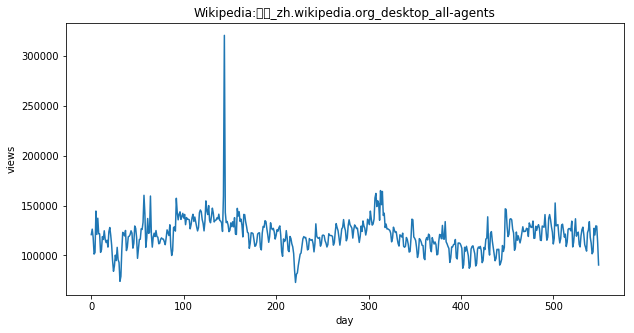

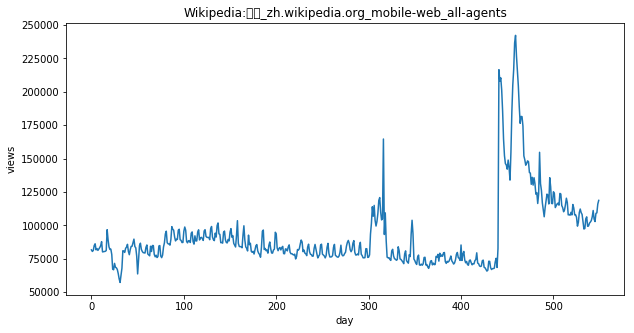

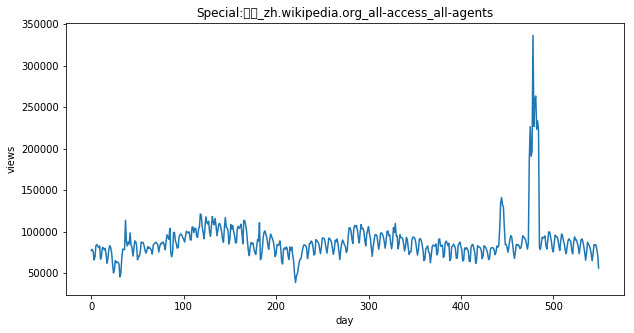

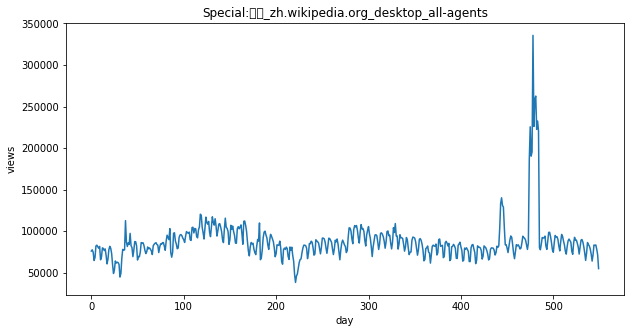

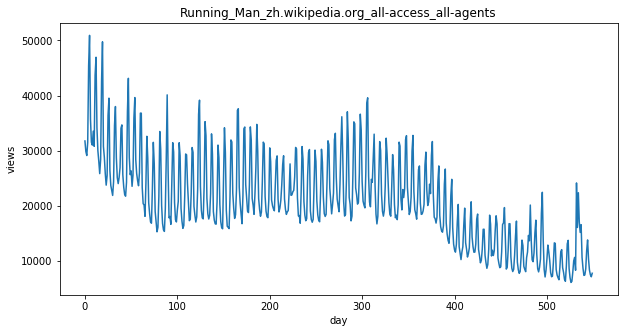

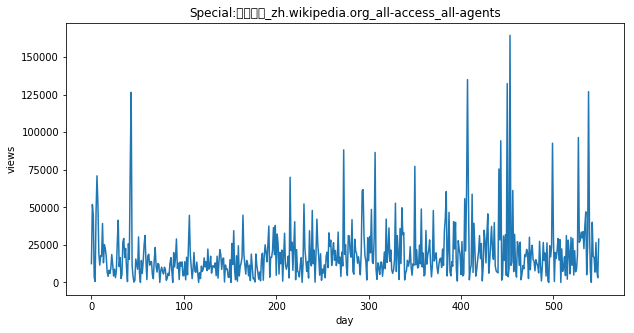

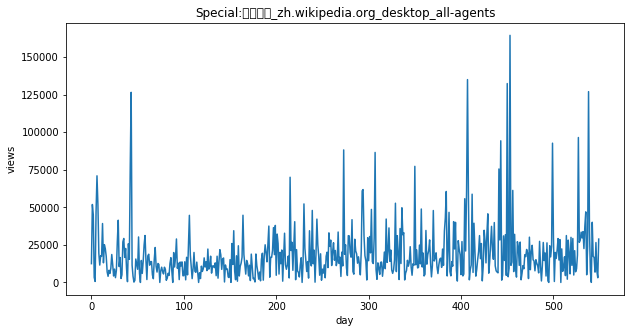

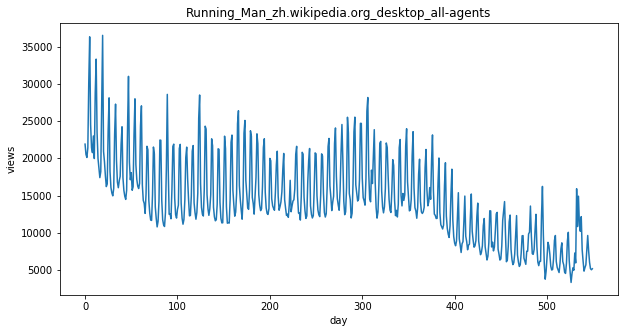

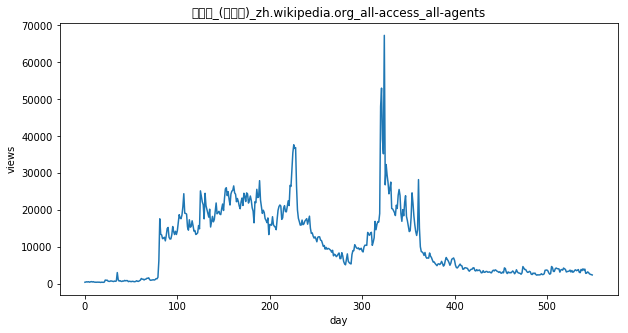

In [32]:
#Review the daily view of the most visited page over the time range. This is the driver for capacity provisioning.
language = 'zh'
#idx = [1, 5, 10, 50, 100, 250,500, 750,1000,1500,2000,3000,4000,5000]
idx = page_popularity[language].sort_values(ascending = False).head(10).index.tolist()
for i in idx:
    plot_entry(language,i)

In [33]:
#lang_sets['en']
lang_sets[key].iloc[:,1:].mean()

2015-07-01    1085.972919
2015-07-02    1037.814557
2015-07-03     954.412680
2015-07-04     896.050750
2015-07-05     974.508210
2015-07-06    1110.637145
2015-07-07    1082.568342
2015-07-08    1050.669557
2015-07-09    1030.841282
2015-07-10     937.129931
2015-07-11     842.808657
2015-07-12     960.246642
2015-07-13    1089.365555
2015-07-14    1144.025801
2015-07-15    1081.183666
2015-07-16    1029.522070
2015-07-17     926.545312
2015-07-18     806.157225
2015-07-19     862.297391
2015-07-20    1012.967588
2015-07-21    1003.396546
2015-07-22    1032.552705
2015-07-23     968.788187
2015-07-24     860.502168
2015-07-25     771.079110
2015-07-26     850.391001
2015-07-27     979.424906
2015-07-28     972.151539
2015-07-29     983.061412
2015-07-30     935.023243
                 ...     
2016-12-02    1126.116568
2016-12-03     910.023314
2016-12-04    1061.265691
2016-12-05    1193.943706
2016-12-06    1269.305494
2016-12-07    1163.406425
2016-12-08    1125.249769
2016-12-09  

In [34]:
#sum_set['total'] = 
#lang_sets['en'].quantile(0.95)*lang_2_pg_size.loc[key,'bits_per_page']

(lang_sets[key])#*lang_2_pg_size.loc[key,'bits_per_page'].astype(int)
#sum_set.sort_values('total',ascending=False)

#sum_set['total'] =
#lang_sets[key]#.T#.iloc[1:-1]#.quantile(0.95)
#sum_set.sort_values('total',ascending=False)

Page  2015-07-01  \
69479      100_metros_es.wikipedia.org_desktop_all-agents         390   
69480   10_Cloverfield_Lane_es.wikipedia.org_desktop_a...           0   
69481   12_de_octubre_es.wikipedia.org_desktop_all-agents          99   
69482   13_de_septiembre_es.wikipedia.org_desktop_all-...          77   
69483   15_de_septiembre_es.wikipedia.org_desktop_all-...          90   
69484   1984_(novela)_es.wikipedia.org_desktop_all-agents         772   
69485            1992_es.wikipedia.org_desktop_all-agents         313   
69486   29_de_febrero_es.wikipedia.org_desktop_all-agents          97   
69487   300:_Rise_of_an_Empire_es.wikipedia.org_deskto...         180   
69488   420_(cannabis)_es.wikipedia.org_desktop_all-ag...         293   
69489      4_de_marzo_es.wikipedia.org_desktop_all-agents          31   
69490    5_de_febrero_es.wikipedia.org_desktop_all-agents          74   
69491     A.J._Styles_es.wikipedia.org_desktop_all-agents          40   
69492           AC/DC_es.wikipedia.org_desktop_all-agents        1543   
69493           AR-15_es.wikipedia.org_desktop_all-agents         142   
69494           ASCII_es.wikipedia.org_desktop_all-agents        1015   
69495   A_Series_of_Unfortunate_Events_es.wikipedia.or...          71   
69496   A_dos_metros_bajo_tierra_es.wikipedia.org_desk...         116   
69497   A_que_no_me_dejas_es.wikipedia.org_desktop_all...           0   
69498    Aaron_Ramsey_es.wikipedia.org_desktop_all-agents          58   
69499   Abandono_escolar_es.wikipedia.org_desktop_all-...           9   
69500   Abierto_de_Australia_2017_es.wikipedia.org_des...           0   
69501          Aborto_es.wikipedia.org_desktop_all-agents        1960   
69502   Abraham_Lincoln_es.wikipedia.org_desktop_all-a...        1017   
69503     Absolutismo_es.wikipedia.org_desktop_all-agents         586   
69504   Acapulco_Shore_es.wikipedia.org_desktop_all-ag...        1863   
69505           Acero_es.wikipedia.org_desktop_all-agents        1226   
69506   Acoso_callejero_es.wikipedia.org_desktop_all-a...          51   
69507   Acoso_escolar_es.wikipedia.org_desktop_all-agents        3749   
69508   Activo_(contabilidad)_es.wikipedia.org_desktop...        1042   
...                                                   ...         ...   
145033  Sin_senos_sí_hay_paraíso_es.wikipedia.org_all-...           0   
145034  Anexo:Medallero_de_los_Juegos_Olímpicos_de_Río...           0   
145035  Arrival_(película)_es.wikipedia.org_all-access...           0   
145036  Anexo:Baloncesto_en_los_Juegos_Olímpicos_de_Rí...           0   
145037  Hasta_que_te_conocí_(serie_de_televisión)_es.w...           0   
145038  Westworld_(serie_de_televisión)_es.wikipedia.o...           0   
145039        Milénico_es.wikipedia.org_all-access_spider           0   
145040  Moonlight_(película)_es.wikipedia.org_all-acce...           0   
145041  Sully_(película)_es.wikipedia.org_all-access_s...           0   
145042  Pulsaciones_(serie_de_televisión)_es.wikipedia...           0   
145043  2091_(serie_de_televisión)_es.wikipedia.org_al...           0   
145044  Campeonato_Sudamericano_de_Fútbol_Sub-20_de_20...           0   
145045  Split_(película)_es.wikipedia.org_all-access_s...           0   
145046  Huracán_Matthew_es.wikipedia.org_all-access_sp...           0   
145047  Fences_(película)_es.wikipedia.org_all-access_...           0   
145048  Logan_(película)_es.wikipedia.org_all-access_s...           0   
145049  La_doña_(telenovela_de_2016)_es.wikipedia.org_...           0   
145050  RTS_(canal_de_televisión)_es.wikipedia.org_all...           0   
145051  La_ley_del_corazón_es.wikipedia.org_all-access...           0   
145052  The_Crown_(serie_de_televisión)_es.wikipedia.o...           0   
145053  Drake_(músico)_es.wikipedia.org_all-access_spider           0   
145054  Skam_(serie_de_televisión)_es.wikipedia.org_al...           0   
145055  Legión_(serie_de_televisión)_es.wikipedia.org_...           0   
145056  Doble_tentación_es.wikipedia.o

In [35]:
# For each language get highest few pages
npages = 1
top_pages = {}


#mean value
for key in lang_sets:
    print(key)
    sum_set = pd.DataFrame(lang_sets[key][['Page']])
    sum_set['total'] = lang_sets[key].sum(axis=1)
    sum_set = sum_set.sort_values('total',ascending=False)
    print(sum_set.head(npages))
    top_pages[key] = sum_set.index[0]
    print('\n\n')
    
    
'''    
#quantile value
for key in lang_sets:
    print(key)
    sum_set = pd.DataFrame(lang_sets[key][['Page']])
    sum_set['total'] = lang_sets[key].quantile(0.95)
    sum_set = sum_set.sort_values('total',ascending=False)
    print(sum_set.head(npages))
    top_pages[key] = sum_set.index[0]
    print('\n\n')'''

en
                                                   Page        total
38573  Main_Page_en.wikipedia.org_all-access_all-agents  12066181102



ja
                                                 Page      total
120336  メインページ_ja.wikipedia.org_all-access_all-agents  210753795



de
                                                     Page       total
139119  Wikipedia:Hauptseite_de.wikipedia.org_all-acce...  1603934248



fr
                                                    Page      total
27330  Wikipédia:Accueil_principal_fr.wikipedia.org_a...  868480667



zh
                                                    Page      total
28727  Wikipedia:首页_zh.wikipedia.org_all-access_all-a...  123694312



ru
                                                    Page       total
99322  Заглавная_страница_ru.wikipedia.org_all-access...  1086019452



es
                                                    Page      total
92205  Wikipedia:Portada_es.wikipedia.org_all-access_...  751492304





"    \n#quantile value\nfor key in lang_sets:\n    print(key)\n    sum_set = pd.DataFrame(lang_sets[key][['Page']])\n    sum_set['total'] = lang_sets[key].quantile(0.95)\n    sum_set = sum_set.sort_values('total',ascending=False)\n    print(sum_set.head(npages))\n    top_pages[key] = sum_set.index[0]\n    print('\n\n')"

In [36]:
len(sum_set)

14069

en


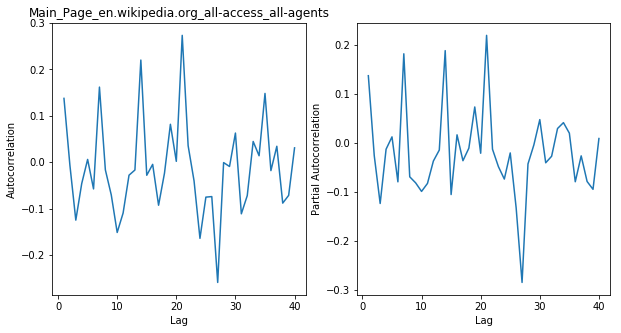

ja


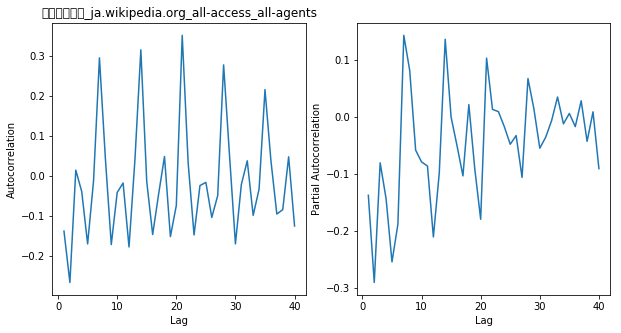

de


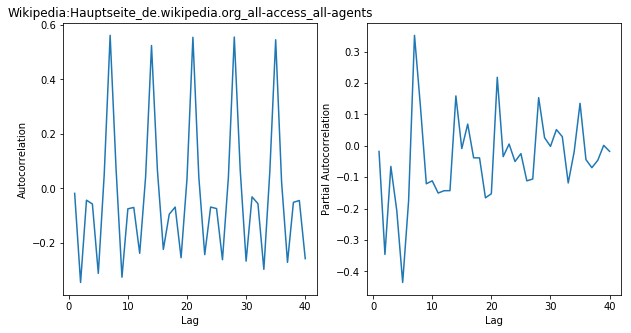

fr


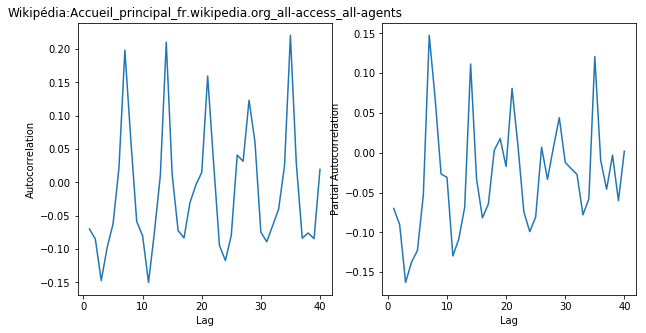

zh


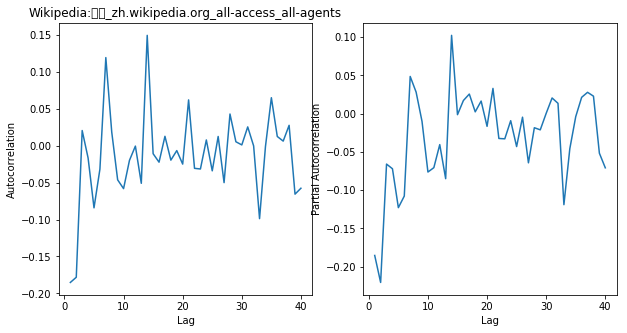

ru


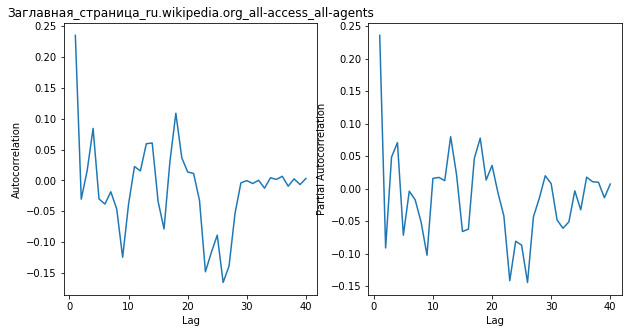

es


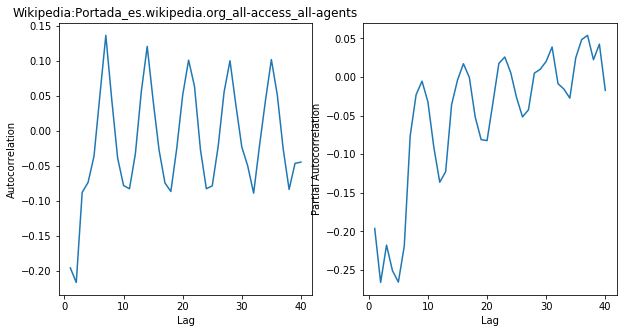

In [37]:
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

for key in top_pages:
    print(key)
    fig = plt.figure(1,figsize=[10,5])
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    cols = train.columns[1:-1]
    data = np.array(train.loc[top_pages[key],cols])
    data_diff = [data[i] - data[i-1] for i in range(1,len(data))]
    autocorr = acf(data_diff)
    pac = pacf(data_diff)
    
    x = [x for x in range(len(pac))]
    ax1.plot(x[1:],autocorr[1:])

    ax2.plot(x[1:],pac[1:])
    ax1.set_xlabel('Lag')
    ax1.set_ylabel('Autocorrelation')
    ax1.set_title(train.loc[top_pages[key],'Page'])

    ax2.set_xlabel('Lag')
    ax2.set_ylabel('Partial Autocorrelation')
    plt.show()


In [38]:
len(np.array(train.loc[top_pages[key],cols]))

550

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
en


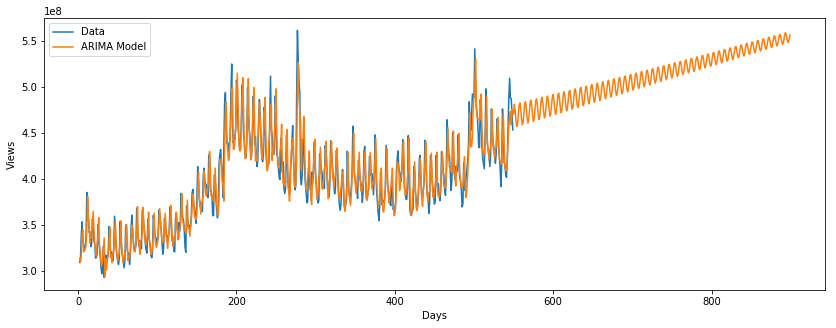

ja


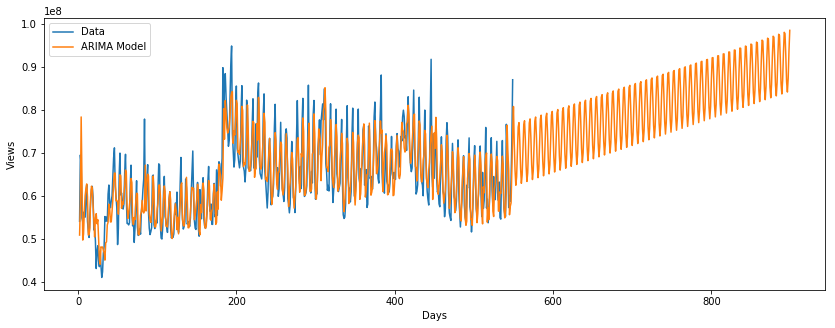

de


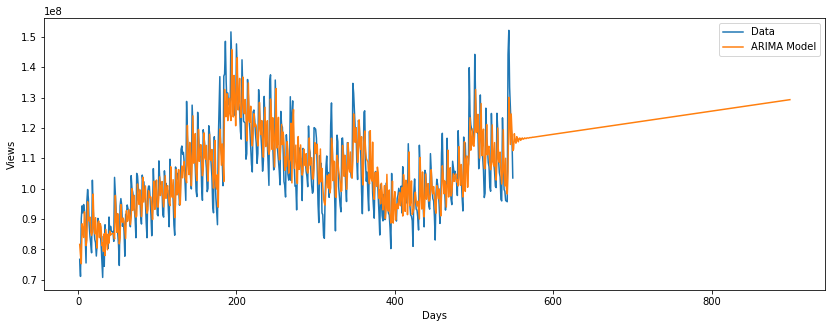

fr


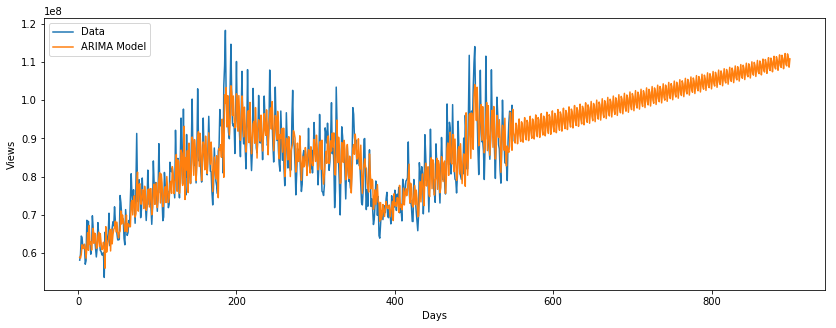

zh


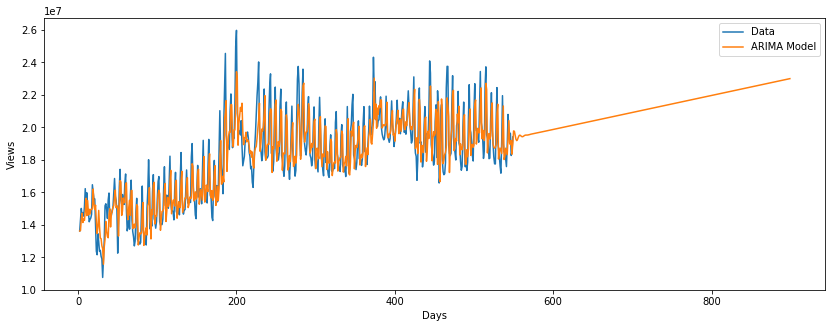

ru


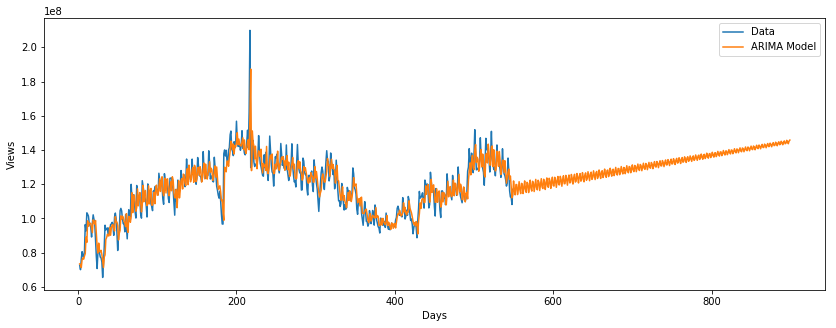

es


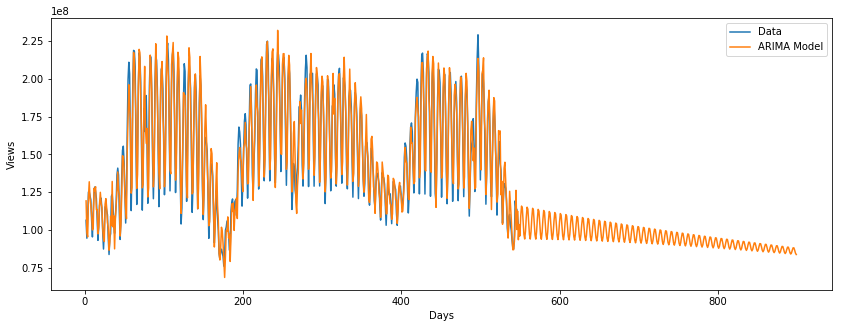

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [39]:
%time
from statsmodels.tsa.arima_model import ARIMA
import warnings

"""This is a view of the quantile 95% view. It has better temporal
stability than the mean statistics for the mean flows"""

lang_sets[key].quantile(0.95)

cols = train.columns[1:-1]
for key in top_pages:
    print(key)
    data = np.array(((lang_sets[key].quantile(0.95))*lang_2_pg_size.loc[key,'bits_per_page'].astype(int)),'f')
    result = None
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            arima = ARIMA(data,[2,1,4])
            result = arima.fit(disp=False)
        except:
            try:
                arima = ARIMA(data,[2,1,2])
                result = arima.fit(disp=False)
            except:
                #print(train.loc[top_pages[key],'Page'])
                print('\tARIMA failed')
    #print(result.params)
    pred = result.predict(2,899,typ='levels')
    x = [i for i in range(900)]
    i=0
    fig = plt.figure(1,figsize=(14,5))
    plt.plot(x[2:len(data)],data[2:] ,label='Data')
    plt.plot(x[2:],pred,label='ARIMA Model')
    #plt.title(train.loc[top_pages[key],'Page'])
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.legend()
    plt.show()
%time

en


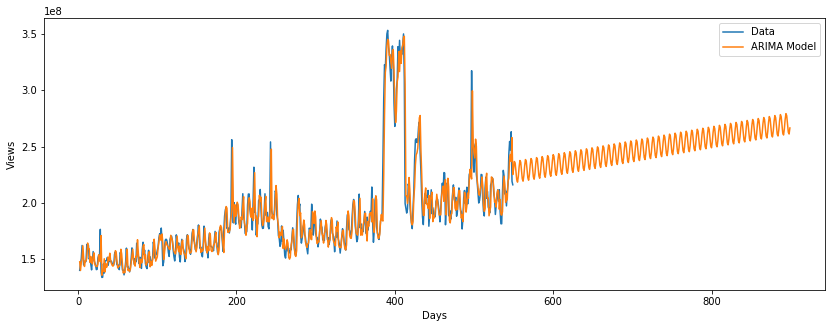

ja


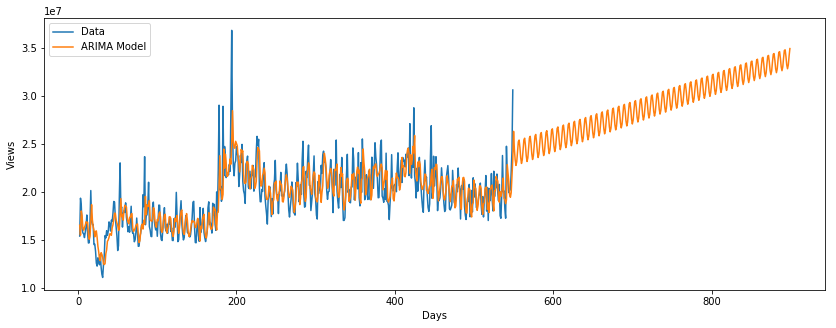

de


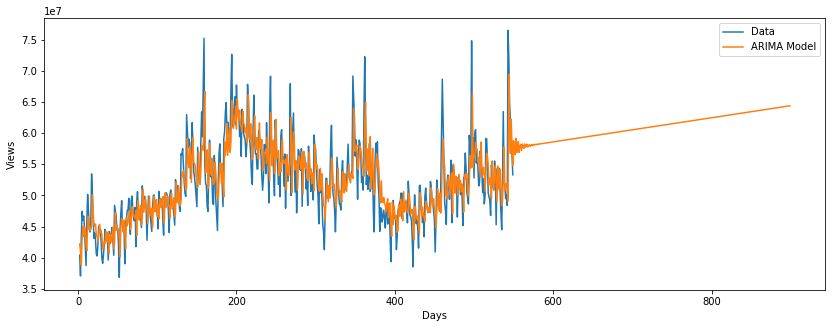

fr


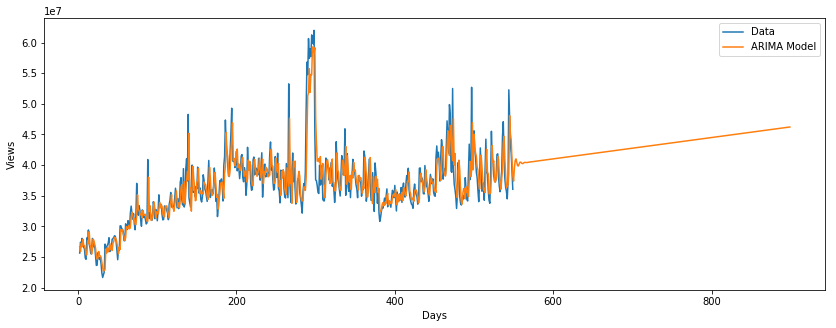

zh


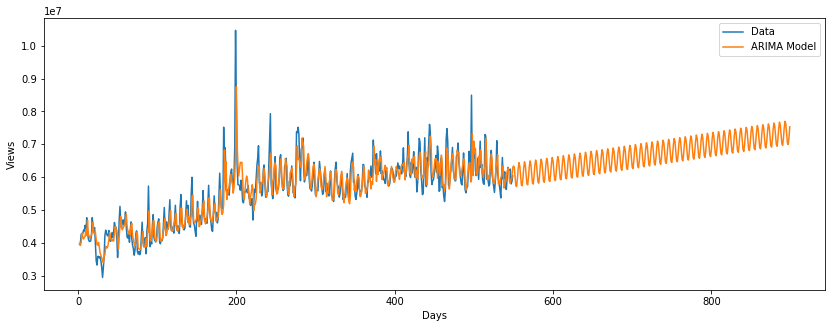

ru


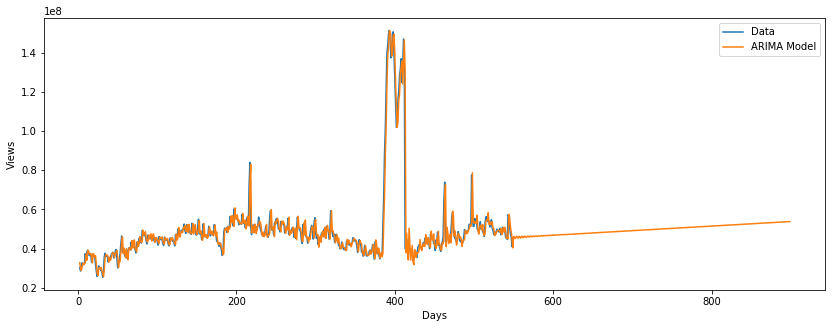

es


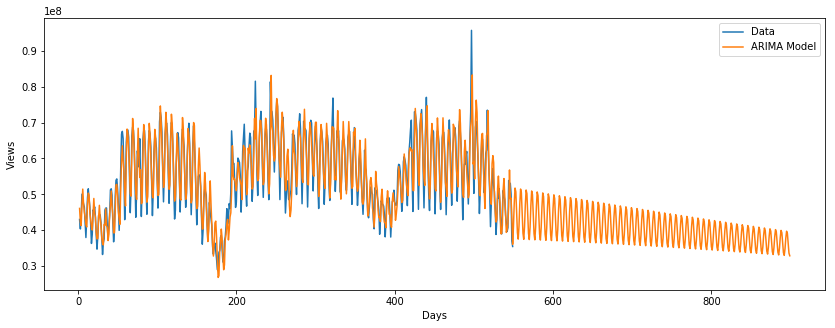

In [40]:
lang_sets[key].quantile(0.95)

cols = train.columns[1:-1]
for key in top_pages:
    print(key)
    data = np.array(((lang_sets[key].iloc[:,1:].mean())*lang_2_pg_size.loc[key,'bits_per_page'].astype(int)),'f')
    result = None
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            arima = ARIMA(data,[2,1,4])
            result = arima.fit(disp=False)
        except:
            try:
                arima = ARIMA(data,[2,1,2])
                result = arima.fit(disp=False)
            except:
                #print(train.loc[top_pages[key],'Page'])
                print('\tARIMA failed')
    #print(result.params)
    pred = result.predict(2,899,typ='levels')
    x = [i for i in range(900)]
    i=0
    fig = plt.figure(1,figsize=(14,5))
    plt.plot(x[2:len(data)],data[2:] ,label='Data')
    plt.plot(x[2:],pred,label='ARIMA Model')
    #plt.title(train.loc[top_pages[key],'Page'])
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.legend()
    plt.show()

In [41]:
#np.array(train.loc[top_pages['en'],cols], 'f') #20381244
#lang_sets[key].quantile(0.95)train.loc[top_pages['en'],cols] #20381245, 20752194

en


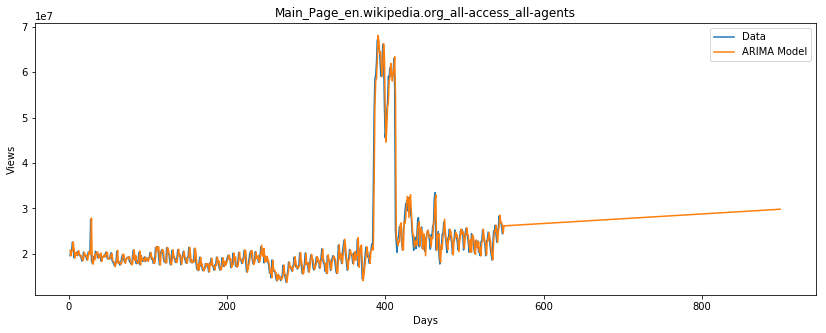

ja


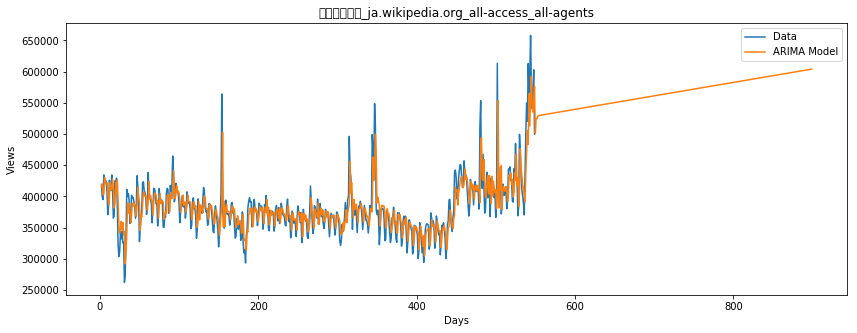

de


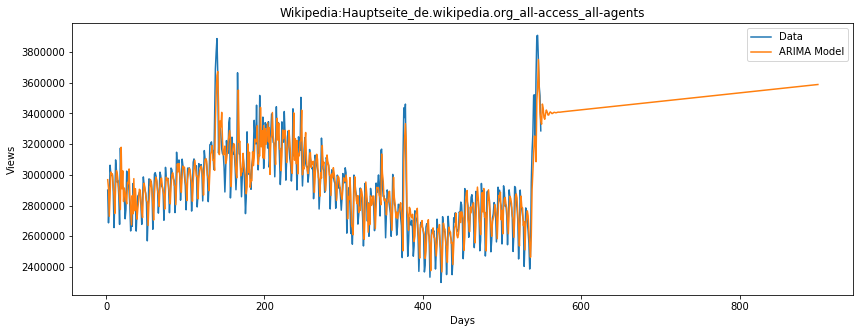

fr


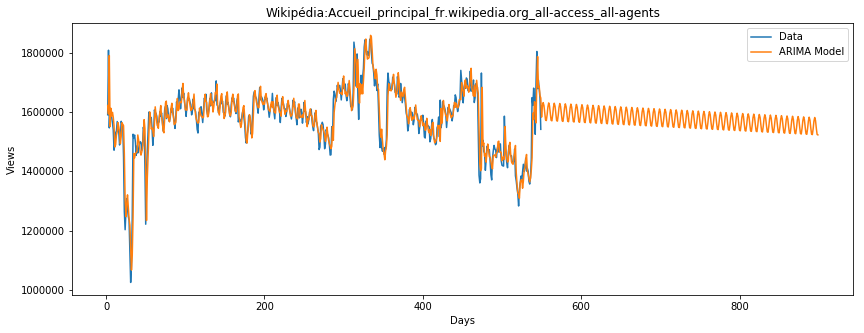

zh


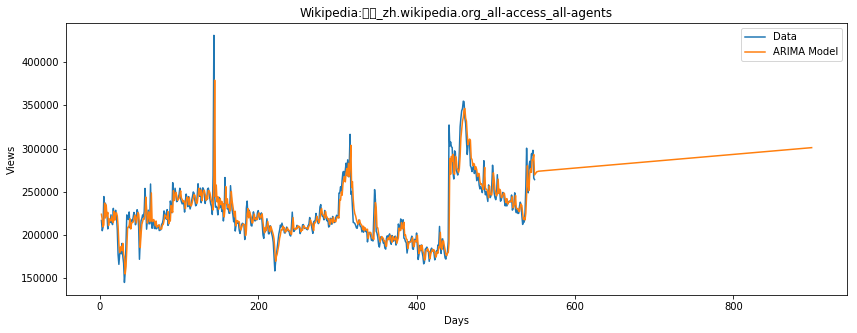

ru


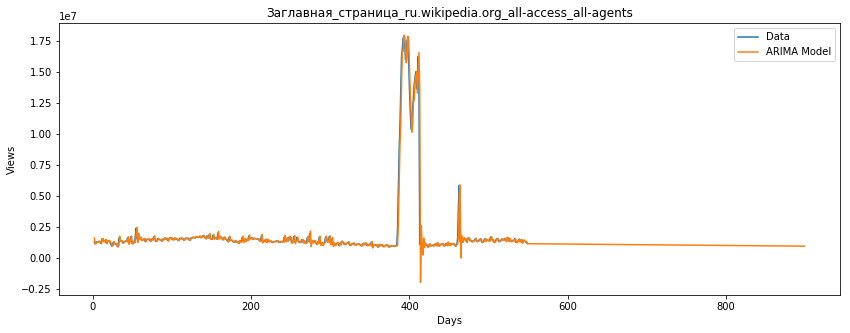

es


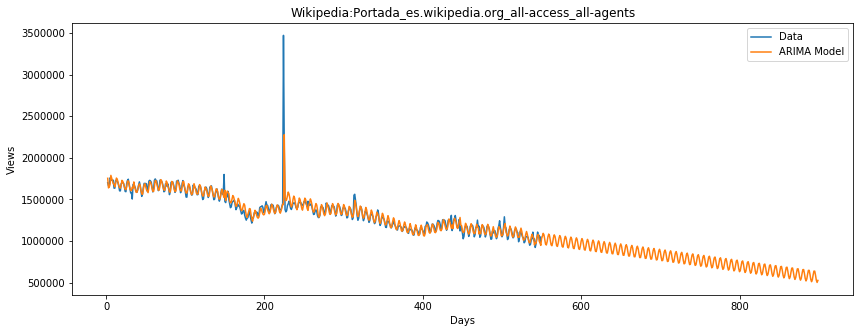

In [42]:
from statsmodels.tsa.arima_model import ARIMA
import warnings

cols = train.columns[1:-1]
for key in top_pages:
    print(key)
    data = np.array(train.loc[top_pages[key],cols],'f')
    result = None
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            arima = ARIMA(data,[2,1,4])
            result = arima.fit(disp=False)
        except:
            try:
                arima = ARIMA(data,[2,1,2])
                result = arima.fit(disp=False)
            except:
                print(train.loc[top_pages[key],'Page'])
                print('\tARIMA failed')
    #print(result.params)
    pred = result.predict(2,899,typ='levels')
    x = [i for i in range(900)]
    i=0
    fig = plt.figure(1,figsize=(14,5))
    plt.plot(x[2:len(data)],data[2:] ,label='Data')
    plt.plot(x[2:],pred,label='ARIMA Model')
    plt.title(train.loc[top_pages[key],'Page'])
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.legend()
    plt.show()

https://meta.wikimedia.org/wiki/Wikimedia_servers

<img src="https://upload.wikimedia.org/wikipedia/commons/d/d8/Wikimedia-servers-2010-12-28.svg"/> 

https://upload.wikimedia.org/wikipedia/commons/d/d8/Wikimedia-servers-2010-12-28.svg

<img src="https://upload.wikimedia.org/wikipedia/commons/5/51/Wikipedia_webrequest_flow_2015-10.png"/> 

In [43]:
'''Retrive Wikimedia infra information. The formatting of te html table in inconsistent, so after the wrangling and
a couple edit in pandas it is converted to csv for another scrub.'''

url_1='https://meta.wikimedia.org/wiki/Wikimedia_servers'
#url_2='https://wikitech.wikimedia.org/wiki/Network_design'
dc = pd.read_html(url_1)[0]
dc.columns=dc.iloc[0]
dc=dc.drop([0])
#dc['Energy kW']=[130,77,10,5,7]
#s=dc['Data center location'].str.split(expand=True)
#s.columns = ['City', 'State','Zip','Country', 'misc']
#s['City'][4]="San Francisco"
#wiki=pd.concat([dc,s], axis=1)
#wiki.to_csv('wiki.csv')
dc

0 Server name         Data center location               Provider  \
1       eqiad  Ashburn, VA 20146-20149 USA      Equinix (Website)   
2       codfw     Carrollton, TX 75007 USA     CyrusOne (Website)   
3       esams  Haarlem 2031 BE Netherlands    EvoSwitch (Website)   
4       ulsfo  San Francisco, CA 94124 USA  UnitedLayer (Website)   
5       eqsin                    Singapore      Equinix (Website)   

0    Date opened Average energy consumption (kW)  \
1  February 2011     May 2016: 130 May 2015: 152   
2       May 2014       May 2016: 77 May 2015: 70   
3  December 2008     May 2016: < 10 May 2015: 10   
4      June 2012     May 2016: < 5 May 2015: < 5   
5              ?                               ?   

0                                     Energy sources  \
1  32% coal 20% natural gas 25% nuclear 17% renew...   
2  23% coal 56% natural gas 6% nuclear 1% hydro/b...   
3   "a combination of wind power, hydro and biomass"   
4  25% natural gas 23% nuclear 30% renewable 6% h...   
5                                                  ?   

0                        Carbon footprint (CO2/year)  \
1  1,040,000 lb = 520 short tons = 470 metric ton...   
2  790,000 lb = 400 short tons = 360 metric tons ...   
3                                                  0   
4  13,000 lb = 6.7 short tons = 6.1 metric tons (...   
5                                                  ?   

0                          Renewable option and cost  
1  In 2015, Equinix made "a long-term commitment ...  
2                                                  ?  
3                                               n.a.  
4                                                  ?  
5                                                  ?

In [44]:
wdf=pd.read_csv('wiki.csv')
wdf

Unnamed: 0 Server name         Data center location               Provider  \
0           1       eqiad  Ashburn, VA 20146-20149 USA      Equinix (Website)   
1           2       codfw     Carrollton, TX 75007 USA     CyrusOne (Website)   
2           3       esams  Haarlem 2031 BE Netherlands    EvoSwitch (Website)   
3           4       ulsfo  San Francisco, CA 94124 USA  UnitedLayer (Website)   
4           5       eqsin                    Singapore      Equinix (Website)   

     Date opened Average energy consumption (kW)  \
0  February 2011     May 2016: 130 May 2015: 152   
1       May 2014       May 2016: 77 May 2015: 70   
2  December 2008     May 2016: < 10 May 2015: 10   
3      June 2012     May 2016: < 5 May 2015: < 5   
4              ?                               ?   

                                      Energy sources  \
0  32% coal 20% natural gas 25% nuclear 17% renew...   
1  23% coal 56% natural gas 6% nuclear 1% hydro/b...   
2   "a combination of wind power, hydro and biomass"   
3  25% natural gas 23% nuclear 30% renewable 6% h...   
4                                                  ?   

                         Carbon footprint (CO2/year)  \
0  1,040,000 lb = 520 short tons = 470 metric ton...   
1  790,000 lb = 400 short tons = 360 metric tons ...   
2                                                  0   
3  13,000 lb = 6.7 short tons = 6.1 metric tons (...   
4                                                  ?   

                           Renewable option and cost  Energy kW  \
0  In 2015, Equinix made "a long-term commitment ...        130   
1                                                  ?         77   
2                                               n.a.         10   
3                                                  ?          5   
4                                                  ?          7   

            City State          Zip      Country  misc  
0       Ashburn,    VA  20146-20149          USA   NaN  
1    Carrollton,    TX        75007          USA   NaN  
2        Haarlem    BE         2031  Netherlands   NaN  
3  San Francisco    CA        94124          USA   NaN  
4      Singapore   NaN          NaN    Singapore   NaN

http://localhost:8888/notebooks/Google/DPP/DC_Cost_Optimization/Models/US%20Network.ipynb

In [45]:
from geopy.exc import GeocoderTimedOut

def do_geocode(address):
    try:
        return geopy.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)

In [46]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()

cities = wdf['City']
location ={}
for city in cities:
    location [city] = geolocator.geocode(city)
locs=pd.DataFrame.from_dict(location).T.reset_index()
locs.columns=['city','address','geometry']

locs['Type']=['Applications', 'Applications','Caching','Caching','Caching']
#locs=locs[locs.columns[-1,1]]
#print(locs.to_latex())
locs

/home/eric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.18.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


city                                 address  \
0       Ashburn,  Ashburn, Loudoun County, Virginia, USA   
1    Carrollton,   Carrollton, Dallas County, Texas, USA   
2        Haarlem       Haarlem, Noord-Holland, Nederland   
3  San Francisco                     SF, California, USA   
4      Singapore   Singapore, Central, 178957, Singapore   

                     geometry          Type  
0   (39.0437192, -77.4874899)  Applications  
1   (32.9537349, -96.8902816)  Applications  
2     (52.3885317, 4.6388048)       Caching  
3  (37.7792808, -122.4192363)       Caching  
4    (1.2904753, 103.8520359)       Caching

In [47]:
#locs=locs[['geometry','address']]
#wiki_locs= geopandas.tools.geocode(wdf.City, provider='yandex')
locs

city                                 address  \
0       Ashburn,  Ashburn, Loudoun County, Virginia, USA   
1    Carrollton,   Carrollton, Dallas County, Texas, USA   
2        Haarlem       Haarlem, Noord-Holland, Nederland   
3  San Francisco                     SF, California, USA   
4      Singapore   Singapore, Central, 178957, Singapore   

                     geometry          Type  
0   (39.0437192, -77.4874899)  Applications  
1   (32.9537349, -96.8902816)  Applications  
2     (52.3885317, 4.6388048)       Caching  
3  (37.7792808, -122.4192363)       Caching  
4    (1.2904753, 103.8520359)       Caching

In [48]:
'''
This has the lat and long coordinate in separate columns. For some reason 
it did not work with the Shapely POINT so it's been suppressed but the orginal 
DF did work so is used now.
'''
#locs=pd.read_csv('coords.csv')
#locs

"\nThis has the lat and long coordinate in separate columns. For some reason \nit did not work with the Shapely POINT so it's been suppressed but the orginal \nDF did work so is used now.\n"

In [49]:
locs['inv']=[(t[1], t[0]) for t in locs.geometry]
locs['Coordinates']=locs['inv'].apply(Point)
locs

city                                 address  \
0       Ashburn,  Ashburn, Loudoun County, Virginia, USA   
1    Carrollton,   Carrollton, Dallas County, Texas, USA   
2        Haarlem       Haarlem, Noord-Holland, Nederland   
3  San Francisco                     SF, California, USA   
4      Singapore   Singapore, Central, 178957, Singapore   

                     geometry          Type                         inv  \
0   (39.0437192, -77.4874899)  Applications   (-77.4874899, 39.0437192)   
1   (32.9537349, -96.8902816)  Applications   (-96.8902816, 32.9537349)   
2     (52.3885317, 4.6388048)       Caching     (4.6388048, 52.3885317)   
3  (37.7792808, -122.4192363)       Caching  (-122.4192363, 37.7792808)   
4    (1.2904753, 103.8520359)       Caching    (103.8520359, 1.2904753)   

                             Coordinates  
0         POINT (-77.4874899 39.0437192)  
1  POINT (-96.89028159999999 32.9537349)  
2           POINT (4.6388048 52.3885317)  
3        POINT (-122.4192363 37.7792808)  
4          POINT (103.8520359 1.2904753)

In [50]:
import geopandas

gdf = geopandas.GeoDataFrame(locs, geometry='Coordinates')

In [51]:
 import matplotlib.pyplot as plt
#fig, ax = plt.subplots()

print(gdf.head())

            city                                 address  \
0       Ashburn,  Ashburn, Loudoun County, Virginia, USA   
1    Carrollton,   Carrollton, Dallas County, Texas, USA   
2        Haarlem       Haarlem, Noord-Holland, Nederland   
3  San Francisco                     SF, California, USA   
4      Singapore   Singapore, Central, 178957, Singapore   

                     geometry          Type                         inv  \
0   (39.0437192, -77.4874899)  Applications   (-77.4874899, 39.0437192)   
1   (32.9537349, -96.8902816)  Applications   (-96.8902816, 32.9537349)   
2     (52.3885317, 4.6388048)       Caching     (4.6388048, 52.3885317)   
3  (37.7792808, -122.4192363)       Caching  (-122.4192363, 37.7792808)   
4    (1.2904753, 103.8520359)       Caching    (103.8520359, 1.2904753)   

                             Coordinates  
0         POINT (-77.4874899 39.0437192)  
1  POINT (-96.89028159999999 32.9537349)  
2           POINT (4.6388048 52.3885317)  
3        POINT (

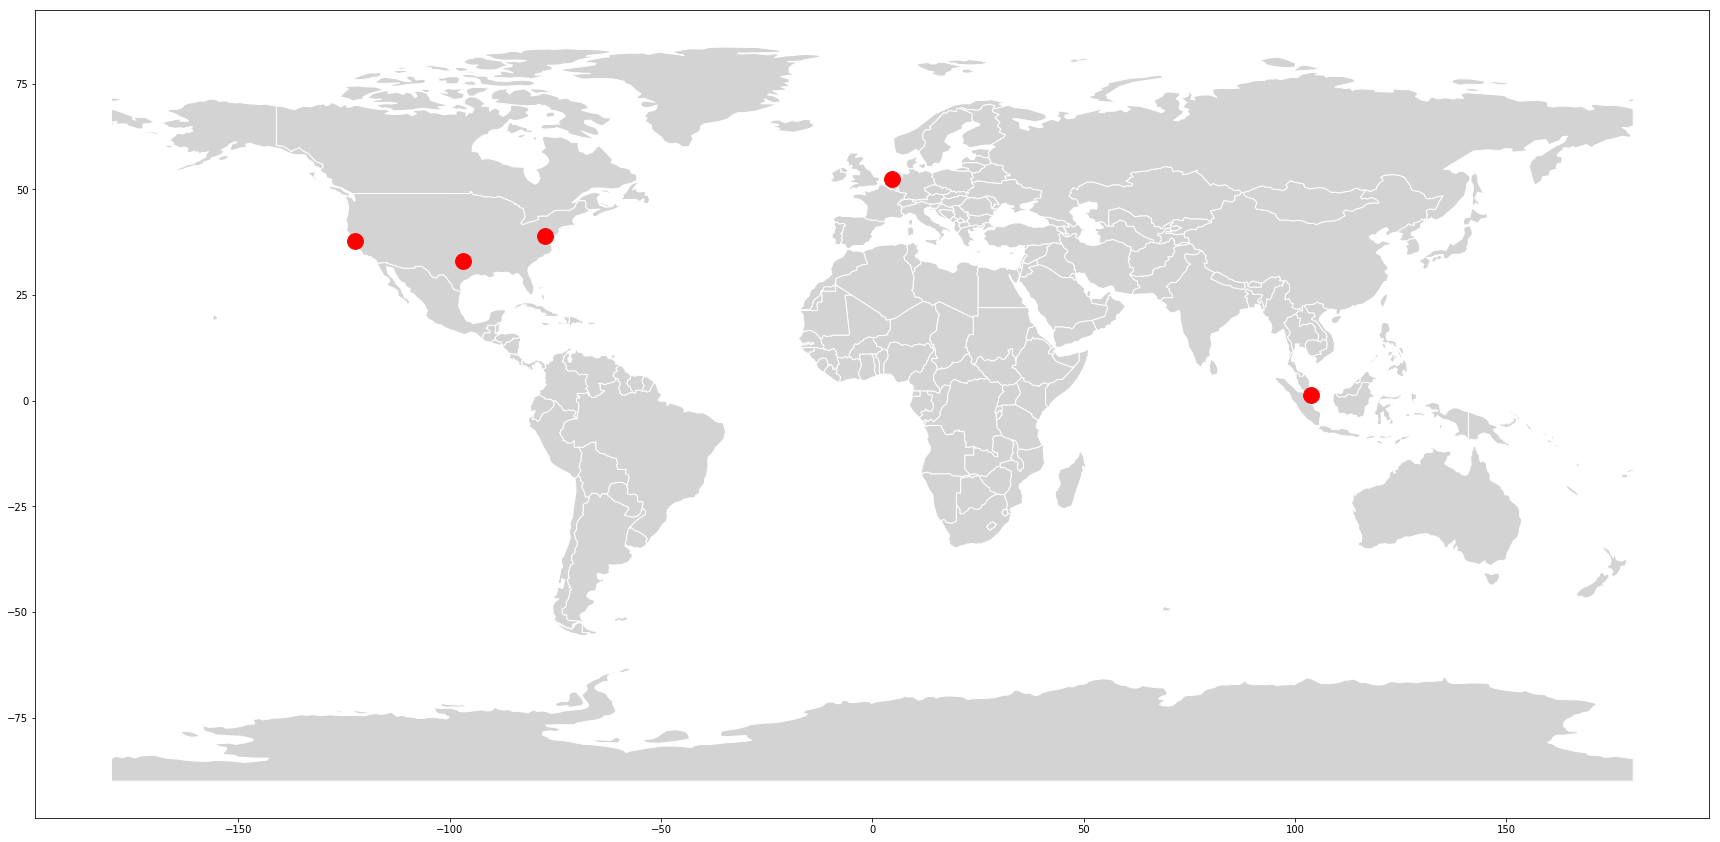

In [52]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
#ax = world[world.continent == 'South America'].plot(
ax = world.plot(
   # color='blue', edgecolor='black')
    color='lightgrey',edgecolor='w', figsize=(30,30))

# We can now plot our GeoDataFrame.
gdf.plot(ax=ax, color='red', markersize=250)

plt.show()

In [53]:
#lang_list=train['lang'].unique().tolist()
lang_list=['zh','en','fr','de','ja','ru','es']
lang_list[1]

'en'

In [54]:
country1=pd.DataFrame(pd.read_html('https://www.internetworldstats.com/languages.htm')[2][0][7:98])
country2=pd.DataFrame(pd.read_html('https://www.internetworldstats.com/languages2.htm')[2][0][8:77])
country3=pd.DataFrame(pd.read_html('https://www.internetworldstats.com/languages3.htm')[2][0][8:82])
country=pd.concat([country1,country2,country3]).reset_index()

language1=pd.DataFrame(pd.read_html('https://www.internetworldstats.com/languages.htm')[2][1][7:98])
language2=pd.DataFrame(pd.read_html('https://www.internetworldstats.com/languages2.htm')[2][1][8:77])
language3=pd.DataFrame(pd.read_html('https://www.internetworldstats.com/languages3.htm')[2][1][8:82])
language=pd.concat([language1,language2,language3]).reset_index()

language = language[1].str.split(expand=True).reset_index()
#language = language[1].str.split(',',expand=False).reset_index()
language[0]=language[0].str.rstrip(',')
language=language[0]

count_lang=pd.concat([country,language], axis=1, sort=False)[6:]
count_lang.columns=['old_index','Country', 'Language']
count_lang=count_lang.drop(columns=['old_index'])

In [55]:
count_lang['wiki_lang'] = count_lang.Language
#count_lang.wiki_lang.replace(['Chin'])
#count_lang.loc[count_lang['Country'] == 'China']
#count_lang.loc[count_lang['Language'] == 'Standard']
count_lang.head()

Country  Language wiki_lang
6              Anguilla   English   English
7   Antigua and Barbuda   English   English
8             Argentina   Spanish   Spanish
9               Armenia  Armenian  Armenian
10                Aruba     Dutch     Dutch

In [56]:
list=language.unique().tolist()
#language.sort_values()
#sorted(list, reverse=False)
count_lang.wiki_lang.replace(['Cantonese','Chinese','English','French','German','Japanese','Mandarin','Russian','Standard','Spanish'],
                             ['zh','zh','en','fr','de','ja','zh','ru','zh','es'], inplace = True)

In [57]:
count_lang=count_lang[(count_lang.wiki_lang == 'en')|(count_lang.wiki_lang == 'zh')
            |(count_lang.wiki_lang == 'es')|(count_lang.wiki_lang == 'fr')
            |(count_lang.wiki_lang == 'de')|(count_lang.wiki_lang == 'ja')
            |(count_lang.wiki_lang == 'ru')]

In [58]:
count_lang.head()

Country Language wiki_lang
6              Anguilla  English        en
7   Antigua and Barbuda  English        en
8             Argentina  Spanish        es
11            Australia  English        en
12              Austria   German        de

In [60]:
countries = count_lang['Country']
geo_code ={}
for country in countries:
    geo_code[country] = geolocator.geocode(country)
    
geos=pd.DataFrame.from_dict(geo_code).T.reset_index()
geos.columns=['Country','address','geometry']

In [61]:
#need to inverse the geo coords - this maybe due to the way GeoPandas coordinates are displayed
geos['inv']=[(t[1], t[0]) for t in geos.geometry]
geos['Coordinates']=geos['inv'].apply(Point)

In [62]:
#type(src_points)
#dst_points.geometry[0].coords.xy
src_points=GeoDataFrame(geos, geometry=geos['Coordinates'])
dst_points=GeoDataFrame(locs, geometry=locs['Coordinates'])

In [63]:
geos['Ashburn']=src_points.distance(dst_points.geometry[0])
geos['Carrollton']=src_points.distance(dst_points.geometry[1])
geos['Haarlem']=src_points.distance(dst_points.geometry[2])
geos['San Francisco']=src_points.distance(dst_points.geometry[3])
geos['Singapore']=src_points.distance(dst_points.geometry[4])
geos['min_dist']=geos[['Ashburn','Carrollton','Haarlem','San Francisco','Singapore']].min(axis=1)
geos['ingress']=geos[['Ashburn','Carrollton','Haarlem','San Francisco','Singapore']].idxmin(axis=1)
geos.tail()

Country                                            address  \
101         Uruguay                                            Uruguay   
102       Venezuela                                          Venezuela   
103  Virgin Islands  United States Virgin Islands, United States of...   
104          Zambia                                             Zambia   
105        Zimbabwe                                           Zimbabwe   

                            geometry                         inv  \
101  POINT (-56.0201525 -32.8755548)  (-56.0201525, -32.8755548)   
102    POINT (-66.1109318 8.0018709)    (-66.1109318, 8.0018709)   
103    POINT (-64.7080574 17.789187)    (-64.7080574, 17.789187)   
104   POINT (27.5599164 -14.5186239)   (27.5599164, -14.5186239)   
105   POINT (29.7468414 -18.4554963)   (29.7468414, -18.4554963)   

                         Coordinates     Ashburn  Carrollton     Haarlem  \
101  POINT (-56.0201525 -32.8755548)   75.054837   77.484597  104.639732   
102    POINT (-66.1109318 8.0018709)   33.060890   39.622770   83.520661   
103    POINT (-64.7080574 17.789187)   24.800585   35.576102   77.499045   
104   POINT (27.5599164 -14.5186239)  117.914724  133.197134   70.724429   
105   POINT (29.7468414 -18.4554963)  121.677285  136.674321   75.161758   

     San Francisco   Singapore   min_dist  ingress  
101      96.958466  163.482214  75.054837  Ashburn  
102      63.697090  170.095424  33.060890  Ashburn  
103      61.075232  169.365618  24.800585  Ashburn  
104     158.835818   77.912869  70.724429  Haarlem  
105     162.224737   76.690829  75.161758  Haarlem

In [64]:
ingress_distribution=pd.DataFrame(geos['ingress'].value_counts())
ingress_distribution

ingress
Haarlem             38
Ashburn             30
Singapore           20
Carrollton          14
San Francisco        4

In [65]:
#count_lang['ingress']=geos['ingress'].copy()
count_lang["ingress"] = count_lang['Country'].astype(str).map(geos.set_index('Country').astype(str)['ingress'])

In [66]:
count_lang.head()

Country Language wiki_lang     ingress
6              Anguilla  English        en     Ashburn
7   Antigua and Barbuda  English        en     Ashburn
8             Argentina  Spanish        es  Carrollton
11            Australia  English        en   Singapore
12              Austria   German        de     Haarlem

In [67]:
count_sets = {}
count_sets['en'] = count_lang[count_lang.wiki_lang=='en'].iloc[:,0:]
count_sets['ja'] = count_lang[count_lang.wiki_lang=='ja'].iloc[:,0:]
count_sets['de'] = count_lang[count_lang.wiki_lang=='de'].iloc[:,0:]
#count_sets['na'] = count_lang[count_lang.wiki_lang=='na'].iloc[:,0:-1] Not using media
count_sets['fr'] = count_lang[count_lang.wiki_lang=='fr'].iloc[:,0:]
count_sets['zh'] = count_lang[count_lang.wiki_lang=='zh'].iloc[:,0:]
count_sets['ru'] = count_lang[count_lang.wiki_lang=='ru'].iloc[:,0:]
count_sets['es'] = count_lang[count_lang.wiki_lang=='es'].iloc[:,0:]

In [68]:
count_sets['en']=count_sets['en'].append({'Country' : 'South Africa' , 'Language' : 'English'} , ignore_index=True)
count_sets['es']=count_sets['es'].append({'Country' : 'Spain' , 'Language' : 'Spanish'} , ignore_index=True)

In [69]:
ingress={}
for key in count_sets:
    ingress[key]=pd.DataFrame(count_sets[key]['ingress'].value_counts())
    ingress[key].columns=[key]
ingress_dist=pd.concat([ingress['en'], ingress['ja'],ingress['de'],ingress['fr'], ingress['zh'],ingress['ru'],ingress['es']], axis=1)
ingress_dist['total'] = ingress_dist.sum(axis=1)
ingress_dist.loc['Total']= ingress_dist.sum()

ingress_dist=ingress_dist.fillna(0)
#print(ingress_dist.fillna('-').to_latex())

ingress_dist

/home/eric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


en   ja   de    fr   zh   ru    es  total
Ashburn        17.0  0.0  0.0   5.0  0.0  0.0   8.0   30.0
Carrollton      3.0  0.0  0.0   0.0  0.0  0.0  11.0   14.0
Haarlem        17.0  0.0  4.0  16.0  0.0  0.0   1.0   38.0
San Francisco   3.0  0.0  0.0   1.0  0.0  0.0   0.0    4.0
Singapore       9.0  1.0  0.0   4.0  5.0  1.0   0.0   20.0
Total          49.0  1.0  4.0  26.0  5.0  1.0  20.0  106.0

In [ ]:
#ingress_dist.loc['Ashburn', 'en']/ingress_dist.loc['Ashburn', 'total']
ingress_sums = {}

for ingress in count_lang.ingress:
        ingress_sums[ingress]=(ingress_dist.loc[ingress, 'en']/ingress_dist.loc['Total', 'en']*sums['en']) + (ingress_dist.loc[ingress, 'ja']/ingress_dist.loc['Total', 'ja']*sums['ja']) + (ingress_dist.loc[ingress, 'de']/ingress_dist.loc['Total', 'de']*sums['de'])+(ingress_dist.loc[ingress, 'fr']/ingress_dist.loc['Total', 'fr']*sums['fr'])+(ingress_dist.loc[ingress, 'zh']/ingress_dist.loc['Total', 'zh']*sums['zh'])+(ingress_dist.loc[ingress, 'ru']/ingress_dist.loc['Total', 'ru']*sums['ru'])+(ingress_dist.loc[ingress, 'es']/ingress_dist.loc['Total', 'es']*sums['es'])
                                                        

In [ ]:
def mean(ingress_loc):
    S = ingress_comps[ingress_loc].mean()
    return S

In [ ]:
ingress_comps=pd.DataFrame(ingress_sums)
ingress_comps.head()

In [ ]:
AMS=mean('Haarlem')
SIN=mean('Singapore')
(SIN-AMS)/(AMS+SIN)*100

In [ ]:
import plotly
import plotly.graph_objs as go
import plotly.offline as py
import cufflinks as cf
py.init_notebook_mode(connected=True)

plotly.tools.set_credentials_file(username='erickumar2019', api_key='ECdS2NcouBB1WDb3lvEO')

In [ ]:
plotly.__version__

In [ ]:
data = ingress_comps[['Ashburn']]
data.index=pd.to_datetime(data.index)

In [ ]:
'''for i in ingress_comps.columns.tolist():
    ingress_comps[i].iplot(title = i)'''

In [ ]:
#data = ingress_comp(['Ashburn']).copy()
#data.iplot(title= "Ashburn")

In [ ]:
from plotly.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data, model='additive')
fig = result.plot()
fig.set_size_inches(12, 18)
plot_mpl(fig)
#fig

In [ ]:
_lang={}
for lang in lang_list:
   # _lang[lang]=pd.DataFrame(count_sets[lang].Country)
    _lang[lang]=count_sets[lang].Country.tolist()
#MyndTrust_lang['en']

In [ ]:
ingress_sums['Ashburn']

In [ ]:
"""result = {}
for i in ingress_comps:
    result[i] = seasonal_decompose(i, model='additive')
    fig = result[i].plot()
    fig.set_size_inches(12, 18)
    plot_mpl(fig)"""

In [ ]:
days = [r for r in range(ingress_sums['Ashburn'].shape[0])]

fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Mean Pages Views')
plt.xlabel('Day')
plt.title('Pages viewed from each ingress site')
labels={'Ashburn':'Ashburn','Carrollton':'Carrollton','Haarlem':'Haarlem',
        'San Francisco':'San Francisco','Singapore':'Singapore',
       }

for key in ingress_sums:
    plt.plot(days,ingress_sums[key],label = labels[key] )
    
plt.legend()
plt.savefig('/home/eric/Google/DPP/DC_Cost_Optimization/cloud_network/Conference-LaTeX-template_7-9-18/ingress_hitrate.jpg') 
#plt.show()

In [ ]:
ingress_sums['Ashburn'].quantile(0.95)

In [ ]:
(pd.DataFrame(result.predict(2,699,typ='levels'))).iloc[-1]

In [ ]:
"""This is a view of the mean view."""
%time
#lang_sets[key].quantile(0.95)

cols = train.columns[1:-1]
for key in ingress_sums:
    print(key)
    data = np.array(ingress_sums[key],'f')
    result = None
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            arima = ARIMA(data,[2,1,4])
            result = arima.fit(disp=True)
        except:
            try:
                arima = ARIMA(data,[2,1,2])
                result = arima.fit(disp=True)
            except:
                #print(train.loc[top_pages[key],'Page'])
                print('\tARIMA failed')
    #print(result.params)
    pred = result.predict(2,699,typ='levels')
    x = [i for i in range(700)]
    i=0
    fig = plt.figure(1,figsize=(14,5))
    plt.plot(x[2:len(data)],data[2:] ,label='Data')
    plt.plot(x[2:],pred,label='ARIMA Model')
    #plt.title(train.loc[top_pages[key],'Page'])
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.legend()
    plt.show()
    print(key, len(x),'th day =',(pd.DataFrame(result.predict(2,699,typ='levels'))).iloc[-1])
%timeit

In [ ]:
""".quantile(0.95)"""

sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].quantile(0.95)#  



ingress_sums = {}
for ingress in count_lang.ingress:
        ingress_sums[ingress]=(ingress_dist.loc[ingress, 'en']/ingress_dist.loc['Total', 'en']*sums['en']) + (ingress_dist.loc[ingress, 'ja']/ingress_dist.loc['Total', 'ja']*sums['ja']) + (ingress_dist.loc[ingress, 'de']/ingress_dist.loc['Total', 'de']*sums['de'])+(ingress_dist.loc[ingress, 'fr']/ingress_dist.loc['Total', 'fr']*sums['fr'])+(ingress_dist.loc[ingress, 'zh']/ingress_dist.loc['Total', 'zh']*sums['zh'])+(ingress_dist.loc[ingress, 'ru']/ingress_dist.loc['Total', 'ru']*sums['ru'])+(ingress_dist.loc[ingress, 'es']/ingress_dist.loc['Total', 'es']*sums['es'])
                                                        

In [ ]:
#data
data1 = pd.DataFrame(ingress_sums['Ashburn'])
data1.columns = ['Ashburn']
data1.info()

In [ ]:
days = [r for r in range(ingress_sums['Ashburn'].shape[0])]

fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Mean Pages Views')
plt.xlabel('Day')
plt.title('Pages viewed from each ingress site (95%tile)')
labels={'Ashburn':'Ashburn','Carrollton':'Carrollton','Haarlem':'Haarlem',
        'San Francisco':'San Francisco','Singapore':'Singapore',
       }

for key in ingress_sums:
    plt.plot(days,ingress_sums[key],label = labels[key] )
    
plt.legend()
plt.savefig('/home/eric/Google/DPP/DC_Cost_Optimization/cloud_network/Conference-LaTeX-template_7-9-18/ingress_hitrate.jpg') 
#plt.show()

In [ ]:
"""This is a view of the mean view."""
%time
#lang_sets[key].quantile(0.95)

cols = train.columns[1:-1]
for key in ingress_sums:
    print(key)
    data = np.array(ingress_sums[key],'f')
    result = None
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            arima = ARIMA(data,[2,1,4])
            result = arima.fit(disp=False)
        except:
            try:
                arima = ARIMA(data,[2,1,2])
                result = arima.fit(disp=False)
            except:
                #print(train.loc[top_pages[key],'Page'])
                print('\tARIMA failed')
    #print(result.params)
    pred = result.predict(2,899,typ='levels')
    #x = [i for i in range(900)]
    #i=0
    fig = plt.figure(1,figsize=(14,5))
    plt.plot(x[2:len(data)],data[2:] ,label='Data')
    plt.plot(x[2:],pred,label='ARIMA Model')
    #plt.title(train.loc[top_pages[key],'Page'])
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.legend()
    plt.show()
    
    %time

In [ ]:
'''from pmdarima import auto_arima #https://libraries.io/pypi/pyramid-arima
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=52,
                           start_P=1, seasonal=True,
                           d=1, D=2, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)'''

In [ ]:
'''stepwise_model.aic()'''

In [ ]:
train2.columns

In [ ]:
training = data.loc['2015-07-01':'2016-9-30']
testing = data.loc['2016-10-01':]

In [ ]:
"""stepwise_model.fit(training)"""

In [ ]:
"""future_forecast = stepwise_model.predict(n_periods=92)"""

In [ ]:
"""print(future_forecast)"""

In [ ]:
"""future_forecast =  pd.DataFrame(future_forecast, index = testing.index,columns=['Prediction'])"""

In [ ]:
"""pd.concat([testing,future_forecast],axis=1).iplot()"""

In [ ]:
def world_plotter(lang1,lang2,lang3, lang4,lang5,lang6,lang7, world_map=True):
    fig,ax = plt.subplots(figsize=(30,30))
    
    if world_map:
        world[0:].plot(ax=ax, alpha = 0.3, color='grey')
        for n in lang1:
            world[world.name == f'{n}'].plot(ax=ax, edgecolor= 'b', linewidth = 2, color='green', alpha=0.3)
        for n in lang2:
            world[world.name == f'{n}'].plot(ax=ax, edgecolor= 'b', linewidth = 2, color='blue', alpha=0.3)
        for n in lang3:
            world[world.name == f'{n}'].plot(ax=ax, edgecolor= 'b', linewidth = 2, color='red', alpha=0.3)
        for n in lang4:
            world[world.name == f'{n}'].plot(ax=ax, edgecolor= 'b', linewidth = 2, color='yellow', alpha=0.3)
        for n in lang5:
            world[world.name == f'{n}'].plot(ax=ax, edgecolor= 'b', linewidth = 2, color='grey', alpha=0.3)
        for n in lang6:
            world[world.name == f'{n}'].plot(ax=ax, edgecolor= 'b', linewidth = 2, color='orange', alpha=0.3)
        for n in lang7:
            world[world.name == f'{n}'].plot(ax=ax, edgecolor= 'b', linewidth = 2, color='magenta', alpha=0.3)
    elif world_map == False:
        for n in country:
            world[world.name == f'{n}'] .plot(ax=ax, edgecolor= 'y', linewidth = 2)
    return gdf.plot(ax=ax, color='red', markersize=250)

In [ ]:
world_plotter(_lang['zh'], _lang['en'], _lang['fr'], _lang['de'], _lang['ja'], _lang['ru'], _lang['es'])
#plt.savefig('/home/eric/Google/DPP/DC_Cost_Optimization/cloud_network/Conference-LaTeX-template_7-9-18/world.jpg') 
#gdf.plot(ax=ax, color='red', markersize=250)

In [ ]:
count_lang.tail()

In [ ]:
locs

In [ ]:
G = nx.Graph()

avg_power=positions = {'EQSIN':10,
            'ULSFO':5,
            'EQDFW':0,
            'CODFW':77,
            'EQORD':0,
            'EQIAD':130,
            'ESAMS':10,
            'KNAMS':0}

positions = {'EQSIN':(-2,-1.5),
            'ULSFO':(1,.75),
            'EQDFW':(3.5,0),
            'CODFW':(5,0),
            'EQORD':(5,1),
            'EQIAD':(8,1),
            'ESAMS':(12,1.5),
            'KNAMS':(12,2.0)}

values = [val_map.get(node, 1) for node in G.nodes()]

#G.add_nodes_from(locs.city)
G.add_weighted_edges_from([
    ('EQIAD', 'ESAMS', 2.0),
    ('EQIAD', 'EQORD', 1.0),
    ('EQIAD', 'KNAMS', 1.0),
    ('CODFW', 'ULSFO', 1.0),
    ('CODFW', 'EQIAD', 3.0),
    ('CODFW', 'EQORD', 1.0),
    ('CODFW', 'ULSFO', 1.0),
    ('EQSIN', 'ULSFO', 1.0),
    ('EQSIN', 'CODFW', 1.0),
    ('ULSFO', 'EQDFW', 1.0),
    ('ULSFO', 'EQORD', 1.0),
    ('EQDFW', 'CODFW', 1.0),
    ('ESAMS', 'KNAMS', 1.0),
])

T = nx.minimum_spanning_tree(G)

plt.figure()
nx.draw(G, with_labels=True, pos=positions, label='Wiki-Network', node_size=1000, font_size=8, node_color='k', alpha=1, width=2, font_color='w', edge_color='r')
plt.show()

#plt.figure()
#nx.draw(T, with_labels=True)
#plt.show()

In [ ]:
power=pd.DataFrame(avg_power, index=[0]).T
power.columns=['avg_power_(kW)']
total_power=power['avg_power_(kW)'].sum()
power['fraction_power'] = (power['avg_power_(kW)']/total_power).map('{:,.2f}'.format)
power
#print(power.to_latex())

In [ ]:
power.index.values

In [ ]:
adjacency_matrix=pd.DataFrame(nx.to_numpy_matrix(G))
adjacency_matrix.columns = G.nodes()
adjacency_matrix.index = G.nodes()
adjacency_matrix=adjacency_matrix.replace(0.0,'-')
print(adjacency_matrix.to_latex())

In [ ]:
adjacency_matrix

In [ ]:
G.nodes()

In [ ]:
url='https://en.wikipedia.org/wiki/Wikipedia:Size_of_Wikipedia'

wiki_summary=pd.read_html(url)[0]

en_wiki_growth=pd.read_html(url)[2]
en_wiki_growth.columns = en_wiki_growth.iloc[0]
en_wiki_growth.drop([0], inplace=True)
en_wiki_growth.drop([19], inplace=True)
en_wiki_growth.replace('228,820[a]', '228,820', inplace=True)
en_wiki_growth.replace('639[a]', '639',inplace=True)

wiki_summary

In [ ]:
wiki_dist_list=[['English', 0.117],
  ['Cebuano', 0.109],
  ['Swedish',0.076],
  ['German',0.046],
  ['French', 0.042],
  ['Dutch',0.04],
  ['Russian', 0.031],
  ['Spanish', 0.03],
  ['Italian',0.03],
  ['Polish',0.027],
  ['Other', .452]]

colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','red', 'salmon', 'green', 'magenta', 'orange', 'b', 'white']    
    

wiki_all_lang_dist=pd.DataFrame(wiki_dist_list, columns=['Language', 'Share'])
wiki_all_lang_dist.index=wiki_all_lang_dist['Language']
title="Wikipedia's Language Distribution"
wiki_all_lang_dist.plot.pie(y='Share',  
                            figsize=(10, 10),
                            title=title , 
                            colors=colors, 
                            autopct='%1.1f%%', 
                            shadow=False, 
                            startangle=90, 
                            wedgeprops   = { 'linewidth' : 1, 'edgecolor' : "green" })

In [ ]:
page_sizes='https://en.wikipedia.org/wiki/Wikipedia:Featured_articles/By_length'
en_page_sizes=pd.read_html(page_sizes)[0].iloc[1:,1:]
en_page_sizes.columns=['topic','size_bytes']
en_page_sizes['size_bytes']=en_page_sizes['size_bytes'].astype(float)
en_page_sizes.plot.hist()

In [ ]:
en_page_sizes.head()

In [ ]:
en_page_sizes.describe()

In [ ]:
#url='https://httparchive.org/reports/state-of-the-web#bytesTotal'
url='https://stats.wikimedia.org/EN/TablesArticlesBytesPerArticle.htm'
art_size=pd.read_html(url)[1] #Jan 31, 2019. This is the final release of Wikistats 1 dump-based reports. 
##pd.read_html(url)[1].to_csv("wiki_lang_stats.csv")

csv='headers.csv'
art_size_col=pd.read_csv(csv)
art_size.columns=art_size_col.iloc[0]
art_size.Date=pd.to_datetime(art_size.Date)
art_size.index=art_size.Date
art_size=art_size[['en','fr','de','ru','es','zh']]
art_size=art_size.dropna(how='all')
fig=art_size.plot()

fig.set_ylabel("Bytes")

#plt.savefig('/home/eric/Google/DPP/DC_Cost_Optimization/cloud_network/Conference-LaTeX-template_7-9-18/art_size.png', bbox_inches = 'tight')
#plt.show()
#fig

In [ ]:
C_datatypes=pd.DataFrame(
             [['[signed]char','unsigned short',1       ,1        ],
              ['short'       ,'unsigned short',2       ,2        ],
              ['int'         ,'unsigned'      ,4       ,4        ],
              ['long'        ,'unsigned'      ,4       ,8        ],
              ['int32_t'     ,'uint32_t'      ,4       ,4        ],
              ['int64_t'     ,'uint64_t'      ,8       ,8        ],
              ['char*'       ,'-'             ,4       ,8        ],
              ['float'       ,'-'             ,4       ,4        ],
              ['double'      ,'-'             ,8       ,8        ]],
             columns=['Signed'      ,'Unsigned'      ,'32-bit','64-bit'])

In [ ]:
print(C_datatypes.to_latex())